In [114]:
import time
from datetime import datetime
import pickle
import numpy as np
import pandas as pd


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
from arch import arch_model

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

import requests
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

---

## <span style="font-family: cursive;">Прогноз цен на металлы.</span>

![Intro](data/intro.jpg)

---

## Описание проекта:
Основная задача:

- Создать модель, прогнозирующую спотовую цену на металл (в нашем случае медь) с горизонтом планирования 3 месяца. Затем аггрегировать показатели по месяцу, выводя среднюю цену периода плюс границы доверительного интервала для прогноза.

- Воссоздать модель в компактном и мобильном виде, как базовый инструмент для более глубокого анализа рынков металлов. С высокой степенью устойчивости в контексте источников данных, что продиктованно необходимостью ежедневного уточнения прогноза.

- Со звездочкой. Задеплоить микросервис на рабочий сервер, но есть нюанс, что этот момент скорее всего будет выполнен в виде подтверждения исполнения, т.к. ели будет приянто решение использовать в реальной работе, то автоматом попадет под внутреннюю разработку нынешней компании и комерческую тайну.

Выбор метрики:

- Для прогнозирования возьмем в расчет ориентир на MAE, RMSE и MAPE. С концентрацией на MAE.

- RMSE измеряет среднеквадратичное отклонение между прогнозируемыми значениями и фактическими значениями. Она более чувствительна к большим ошибкам, так как она берет квадрат каждой ошибки. RMSE также имеет ту же размерность, что и исходные данные, что может быть полезно для интерпретации результатов.

- MAE, с другой стороны, измеряет среднюю абсолютную ошибку между прогнозируемыми значениями и фактическими значениями. Она не учитывает направление ошибки и может быть полезна, когда все ошибки равнозначны, что для нас является ключевым фактором при прогнозе средних значений.

- Пороговым значением MAE примем 150-200$.

Описание датасета:

- Датасет парсится с сайта westmetall, который в свою очередь аггрегирует информацию с Лондонской биржи металлов (LME).

- Избан единственный источник данных в следствие необходимости создания бенчмарка для LME высокой степени устойчивости, что с одной стороны понижает точность прогноза (наиболее вероятно), но с другой обеспечивает надежность. 

- В данном исследовании приводится анализ единственного металла, но парсер пополняет базу данных для всех ключевых non-ferrous metalls. Данные не имеют как таковых выбросов, т.к. формируются на основании временных рядов цен и запасов металлов, отражая реальную коньюктуру рынка, но могут содержаться аномалии.

P.S. Для упрощения анализа других металлов максимально унифицировал шаблон действий. В соседних файлах будет аналитика по аллюминию, цинку, свинцу, никелю.

---

### Технический блок.

### Содержание:
- Без парсера, берем данные из базы.
- Функции для использования в исследовании

---

- Работа будет проводиться с датасетом по меди, но в будущем, в случае подтверждения основных тезисов работоспособности модели, планируется внедрение данного алгоритма для формирования легковесного бенчмарка для группы металлов.

In [115]:
# Функция для проверки ряда на стационарность и вывода графиков автокорреляции полной и частичной
def stationary_test(data, name='заглушка', crit_value='5%', graph='yes', figsize=(7, 9)):
    if graph == 'yes':
        # Графики автокорреляции полной и частичной
        fig, axes = plt.subplots(2, 1, figsize=figsize)
        plot_acf(data, ax=axes[0], title=f'Автокорреляция {name}')
        plot_pacf(data, ax=axes[1], title=f'Частичная автокорреляция {name}')
    else:
        pass

    # Тест на стационарность
    test = adfuller(data)
    p_value = test[0]
    crit_value = test[4][crit_value]
    if p_value > crit_value:
        print('Есть единичные корни, ряд не стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})
    else:
        print('Единичных корней нет, ряд стационарен')
        print({'p_value': p_value, 'crit_value (5%)': crit_value})

In [116]:
# Функция для расчета RMSE, MAE и MAPE
def metrics_calculation(test_df, pred_df, name='заглушка'):
    # Переменная для логирования даты эксперимента
    date_of_experiment = pd.to_datetime(datetime.today().date())

    print(
        f'RMSE для {name}: {(rmse := np.sqrt(mean_squared_error(test_df, pred_df)).round(3))}')

    # По MAE
    print(
        f'MAE для {name}: {(mae := mean_absolute_error(test_df, pred_df).round(3))}')

    # По MAPE
    print(
        f'MAPE для {name}: {(mape := mean_absolute_percentage_error(test_df, pred_df).round(3)*100)}%')

    print('\n')
    result_row = f'\n{date_of_experiment},{name},{rmse},{mae},{mape}'

    return result_row

In [117]:
# Функция для логирования метрик
def log_metrics_stock(metric):
    with open('./data/errors/stock_zink.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/stock_zink.csv', 'a') as file:
                file.write(metric)


def log_metrics_spot(metric):
    with open('./data/errors/spot_zink.csv', 'r') as file:
        file_content = file.read()
        if metric in file_content:
            print("Дубликат значения metric. Не сохраняем.")
        else:
            # Сохраняем значение metric_stock в файл
            with open('./data/errors/spot_zink.csv', 'a') as file:
                file.write(metric)

In [118]:
# Функция для построения графиков
def visualisation_prog(pred_df, forecast_df, train_df, test_df, name=''):
    plt.plot(pred_df, label='Prediction')
    plt.plot(forecast_df, linestyle='--', label='Confidence Interval')
    plt.plot(train_df, label='Training Data')
    plt.plot(test_df, label='Test Data')
    plt.title(f'Прогноз для {name}')
    plt.legend()
    plt.show()

In [119]:
# Функция для кодирования даты
def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)

---

### Часть 0.

- Предподготовка данных, первичный анализ и формирование датафреймов для последующих этапов.

In [120]:
# Блок предподготовки полученных данных
# Обработка данных полученных с lme
data = pd.read_csv('./data/zink.csv',
                parse_dates=['date'], index_col=['date'])

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
count,3981.000000,3981.000000,3981.000000
mean,2350.660136,2308.413715,430.826049
std,580.032871,652.658898,323.659455
min,0.000000,0.000000,0.000000
25%,1936.500000,1930.500000,152.225000
50%,2270.500000,2270.500000,351.875000
75%,2709.500000,2698.000000,669.875000
max,4530.000000,4460.000000,1235.975000


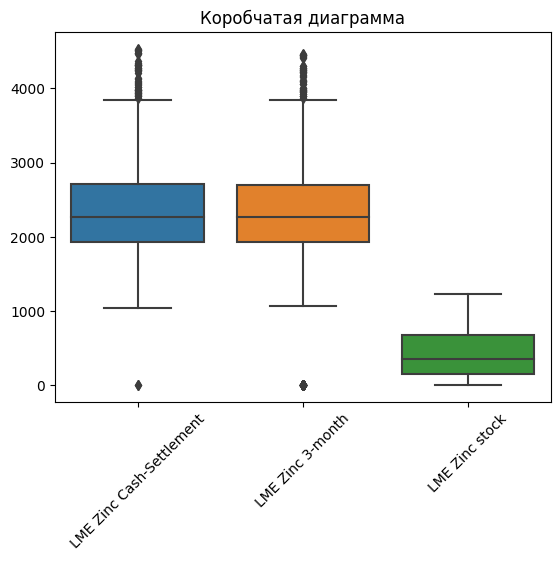

In [121]:
# В данном случае понятие выброса отсуствует, т.к. датасет составлен из
# реальных финансовых данных, следовательно мы должны выявить аномалии,
# конкретно здесь это нулевые значения в изначальном, неинтрерполированном
# датасете.

box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

> Мы обнаружили аномалию - пропуск в данных

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
count,3898.000000,3898.000000,3898.000000
mean,2353.285788,2356.894818,437.059999
std,582.717680,566.156412,324.042082
min,1042.000000,1069.000000,15.600000
25%,1930.500000,1946.500000,159.150000
50%,2270.500000,2278.750000,364.975000
75%,2724.000000,2719.750000,678.287500
max,4530.000000,4460.000000,1235.975000


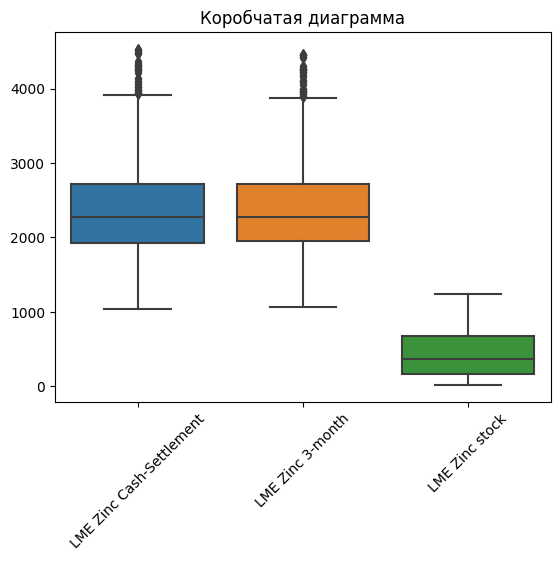

In [122]:
# Удаление ошибки
data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

# Убедимся в отсутвие пропусков
box = sns.boxplot(data=data)
box.set_title('Коробчатая диаграмма')
box.set_xticklabels(box.get_xticklabels(), rotation=45)

data.describe()

- Для последующего разложения и моделирования было принято решени о произведении интерполяции данных, итоговая точность прогноза от данных действий пострадает не сильно, учитывая, что нас не интересует дневной уровень цены

In [123]:
# Произведем интерполяцию
data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [124]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1])
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME Copper 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену меди для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[data['date'].dt.year != 2008]

display(data.head(), data.tail())

,date,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
365,2009-01-01,1170.500000,1580.000000,253.4875
366,2009-01-02,1220.500000,1568.333333,253.4750
367,2009-01-03,1225.666667,1556.666667,253.8250
368,2009-01-04,1230.833333,1545.000000,254.1750
369,2009-01-05,1236.000000,1536.000000,254.5250


,date,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
85,2023-12-22,NaN,2539.0,NaN
86,2023-12-23,NaN,2530.0,NaN
87,2023-12-24,NaN,2528.0,NaN
88,2023-12-25,NaN,2487.0,NaN
89,2023-12-26,NaN,2579.5,NaN


---

#### Посмотрим на корреляцию между параметрами и целевой переменной

Диапазон планирования равен 90 дней


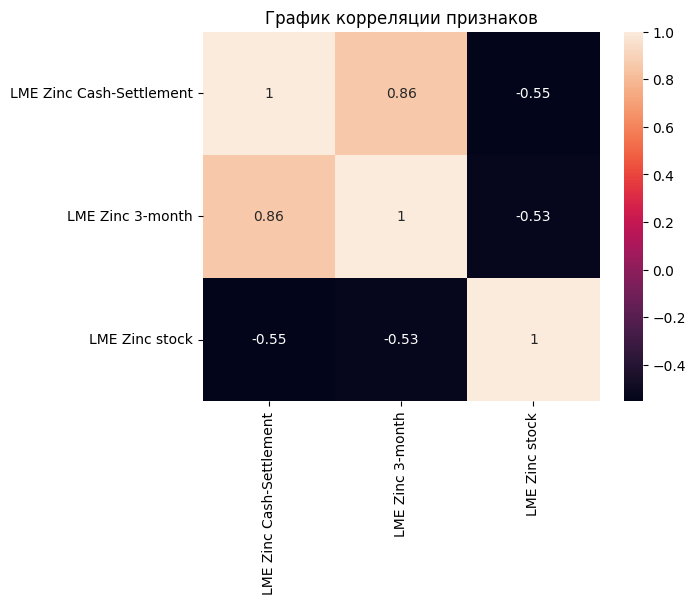

In [125]:
# Выделим ту часть датафрейма, которую мы будем в дальнейшем прогнозировать за счет информации по фьючерсам и спрогнозированным запасам
data_target = data[data.iloc[:, 3].isna()]
data_target.set_index('date', inplace=True)
# А так же ту часть, которую будем использовать для работы
working_data = data[~data.iloc[:, 3].isna()]
working_data.set_index('date', inplace=True)

corr_graph = sns.heatmap(data=working_data.corr(), annot=True)
corr_graph.set_title('График корреляции признаков')
print(f'Диапазон планирования равен {data_target.shape[0]} дней')

> Можно наблюдать высокий уровень корреляции между фьючерсной ценой и спотом, что понадобится нам потом и какую-то между запасами и спотом, что тоже лучше чем ничего.
> На основании того что у нас есть фиты с сильной корреляцией к целевой переменной, мы можем попробовать что-то большее чем стандартный набор для прогнозирования временных рядов.

---

Исходя из первичного анализа данных вырисовывается следующий план:
- Протестировать модели прогноза временных рядов для запасов и цены с последующим логированием
- Протестировать ML- методы линейной регрессии

---

#### Посмотри на распределение показателей с которыми мы будем работать

<Axes: xlabel='LME Zinc Cash-Settlement', ylabel='Count'>

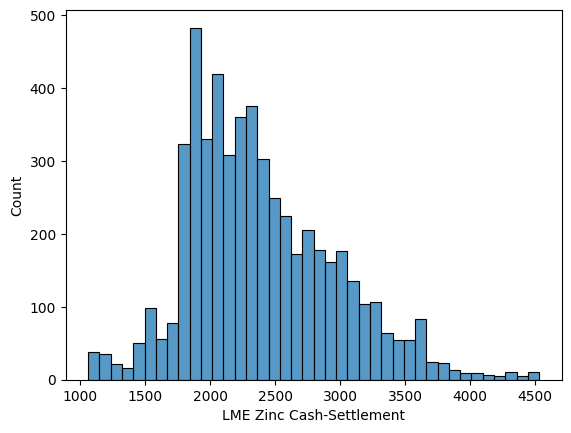

In [126]:
# Посмотрим на распределения цены и запасов
sns.histplot(data.iloc[:, 1])

По цене нормальное распределение

<Axes: xlabel='LME Zinc stock', ylabel='Count'>

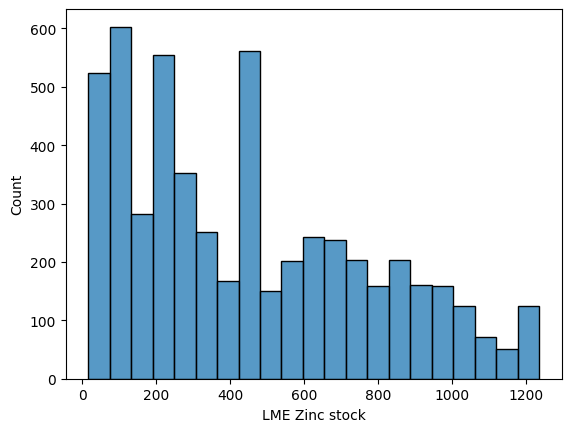

In [127]:
sns.histplot(data.iloc[:, -1])

<Axes: xlabel='LME Zinc stock', ylabel='Count'>

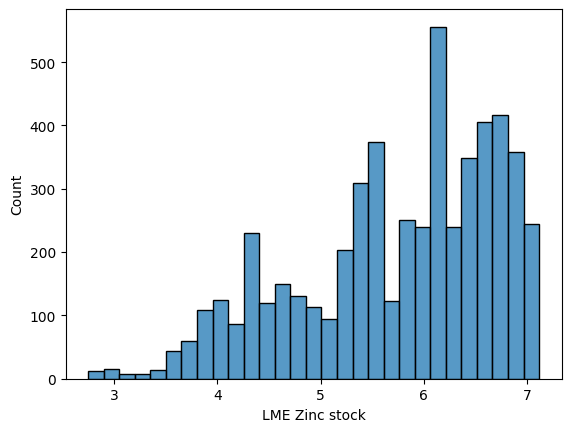

In [128]:
sns.histplot(np.log(data.iloc[:, -1]))

По запасам логнормальное, это может понадобиться в будущем (не понадобится, в итоге лучше принимать его за нормальное и не логарифмировать, но об этом позже)

---

Предварительный вывод и личные коментарии:
- Наша задача сформировать прогноз на 90 дней вперед, исходя из предположения о том, что сдвинутые на 3 месяца данные по фьючерсам (со сроком исполнения в 3 месяца, потому такой сдвиг) имеют высокую корреляцию с показателем целевой переменной спотовой цены.

- Так же нужно отметить достаточный уровень обратной корреляции между спотом и запасами, что логично исходя из закона о спросе и предложении, при этом влияние запасов на фьючерсы не несет характер мультиколлинеарности.

- Хотел бы отметить, что был эксперимент с внедрением данных из разных источников, но с целевой переменной корреляция была слишком слаба, при этом сильно усложнялся этап парсинга и последующей автоматизации скрипта, который в планах перевести на микросервис, т.е. затраты и потери от внедрения доп информации был слишком дорог для реального применения.

----

### Часть 1.

### Прогнозирование временного ряда запасов (LME stock) и спотовой цены (LME Cash-Settlement)

#### Первичный анализ данных.

In [129]:
# Будем прогнозировать временной ряд LME Copper stock и
# LME Copper Cash-Settlement, т.к. данная переменная имеет непосредственную связь с фактором времени
# Для начала проведем декомпозицию временных рядов

stock = working_data.iloc[:, 2]
spot = working_data.iloc[:, 0]

decompose_stock = seasonal_decompose(stock)
decompose_spot = seasonal_decompose(spot)

# Выделим тренд, сезонность и остатки, интерполируем и заполним нулями первые элементы
trend_stock = decompose_stock.trend
seasonal_stock = decompose_stock.seasonal
seasonal_stock = seasonal_stock.resample('d').interpolate(method='linear')
seasonal_stock.fillna(0, inplace=True)
residuals_stock = decompose_stock.resid
residuals_stock = residuals_stock.resample('d').interpolate(method='linear')
residuals_stock.fillna(0, inplace=True)

trend_spot = decompose_spot.trend
seasonal_spot = decompose_spot.seasonal
seasonal_spot = seasonal_spot.resample('d').interpolate(method='linear')
seasonal_spot.fillna(0, inplace=True)
resid_spot = decompose_spot.resid
resid_spot = resid_spot.resample('d').interpolate(method='linear')
resid_spot.fillna(0, inplace=True)

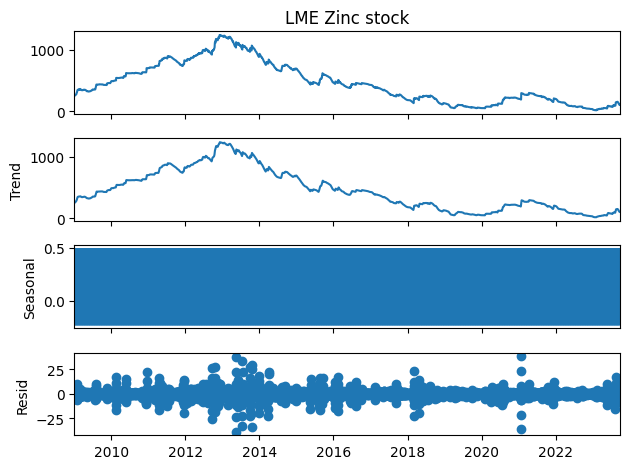

In [130]:
# Произвведем декомпозицию ряда
decompose_stock.plot()
plt.show()

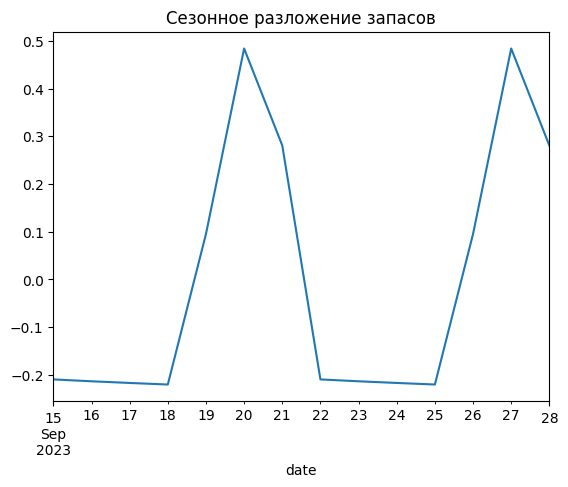

In [131]:
# Приблизим сезонность
graph = decompose_stock.seasonal[-14:].plot()
graph.set_title('Сезонное разложение запасов')
plt.show()

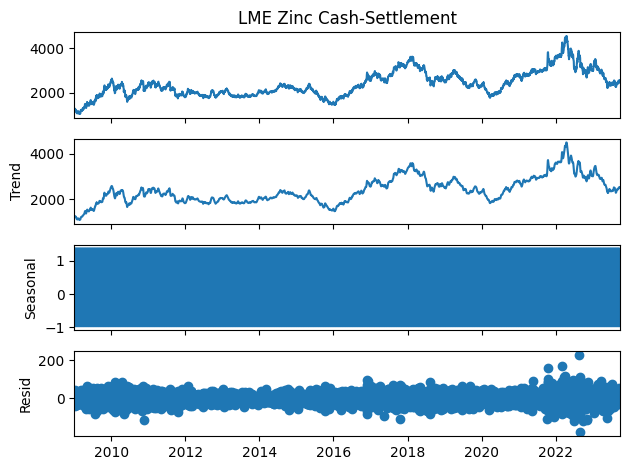

In [132]:
# Для цены
decompose_spot.plot()
plt.show()

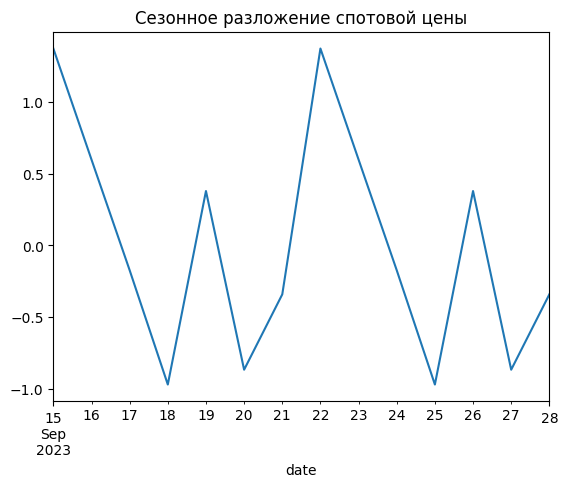

In [133]:
graph = decompose_spot.seasonal[-14:].plot()
graph.set_title('Сезонное разложение спотовой цены')
plt.show()

> Вывод: Мы можем наблюдать большие остатки при сезонном разложении спотовых цен, вероятной причиной этого может быть влияние экзогенных факторов, от глобальных циклов экономики и геополитических сдвигов, до возможных спекулятивных манипуляций, уже на данном этапе можно сказать, что прогнозирование цены влоб, через ARIMA будет не самой разумной идеей. Возможно сработал бы подход с анализом и прогнозом остатков параллельно с основной компонентой.

> С запасами картина более радужная, физические запасы металла на бирже величина менее волатильная, что вселяет надежду в возможность формирования прогноза данной величины и использования ее как фактора в другом типе мл, но об этом позже.

> Так же нужно отметить сезонность равную периоду 7 дней (5 дней ьез интерполяции), что характерно для биржевых показателей.


---

Единичных корней нет, ряд стационарен
{'p_value': -10.773989714709403, 'crit_value (5%)': -2.862080088241299}
Единичных корней нет, ряд стационарен
{'p_value': -47.109357452799415, 'crit_value (5%)': -2.862077277127936}


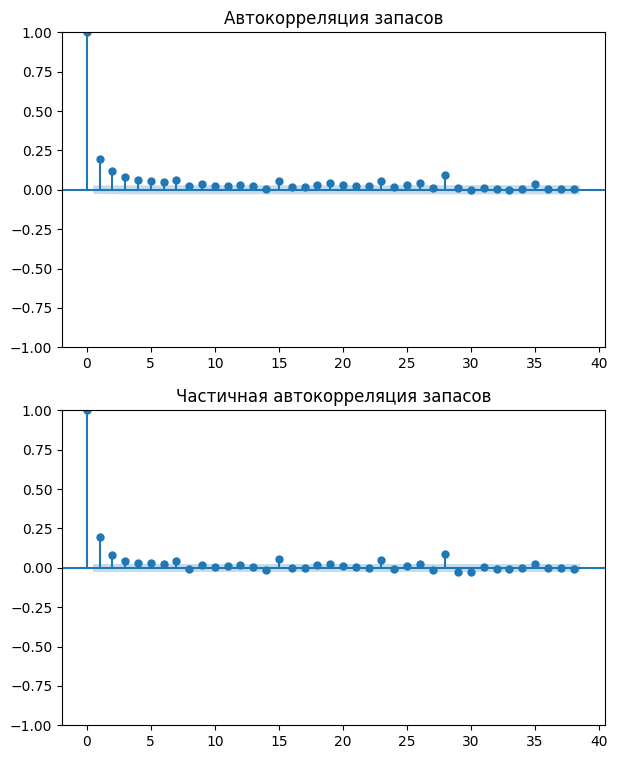

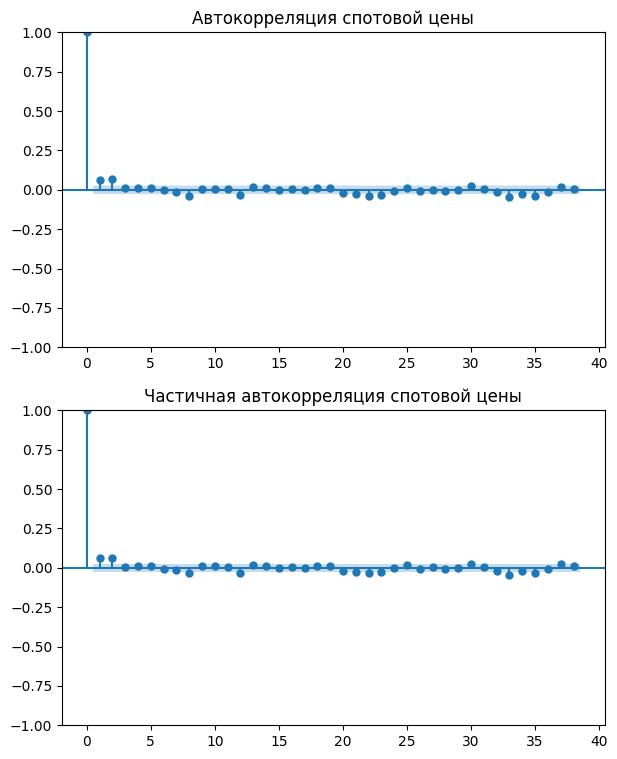

In [134]:
# Проведем тест стационарности выведем графики acf и pacf
stationary_test(stock.diff().dropna(), name='запасов')
stationary_test(spot.diff().dropna(), name='спотовой цены')

> Вывод: оба ряда стационарны при дифференцировании 1 порядка, стоит отметить что ряд запасов условно стационарен (не все статистика близка к порогу 5%)

> p для запасов равен 1 (исходя из pacf графика это значение равно 2, но лучшие результаты были достигнуты именно при значении 1)

> p для спота равен 2 (так же исходя из pacf)

In [135]:
p_stock = 1
d_stock = 0
q_stock = 0

p_spot = 1
d_spot = 0
q_spot = 0

---

#### Baseline модель для данного этапа исследования.

##### Здесь мы убьем двух зайцев и сразу спрогнозируем и спот и запасы через базовую авторегрессионную модель, далее мы так же будем прогнозировать спок прайс, хоть изначально и планировалось сформировать для него конечный прогноз через random-forest regressor через фиты фьючерса и запасов, но может статься что по итогу выиграет простая стратегия.

In [136]:
# Выделим тренировочную и тестовую выборки
train_stock = stock[:-len(data_target)]
test_stock = stock[-len(data_target):]

train_spot = spot[:-len(data_target)]
test_spot = spot[-len(data_target):]

# Сделаем то же самое для сезонных компонент
seasonal_stock_train = seasonal_stock[:-len(data_target)]
seasonal_stock_test = seasonal_stock[-len(data_target):]

residuals_stock_train = residuals_stock[:-len(data_target)]
residuals_stock_test = residuals_stock[-len(data_target):]

seasonal_spot_train = seasonal_spot[:-len(data_target)]
seasonal_spot_test = seasonal_spot[-len(data_target):]

resid_spot_train = resid_spot[:-len(data_target)]
resid_spot_test = resid_spot[-len(data_target):]

# И попробуем создать корректировку для послежующих прогнозов через базовую модель
ar_model_stock_sesonal = AutoReg(seasonal_stock_train, lags=1).fit()
ar_model_stock_resid = AutoReg(residuals_stock_train, lags=1).fit()

ar_model_spot_seasonal = AutoReg(seasonal_spot_train, lags=1).fit()
ar_model_spot_resid = AutoReg(resid_spot_train, lags=1).fit()

In [137]:
# Наши корректировки
stock_seasonal_mod = ar_model_stock_sesonal.predict(start=len(
    seasonal_stock_train), end=len(seasonal_stock_train)+len(seasonal_stock_test)-1)
stock_resid_mod = ar_model_stock_resid.predict(start=len(
    residuals_stock_train), end=len(residuals_stock_train)+len(residuals_stock_test)-1)

spot_seasonal_mod = ar_model_spot_seasonal.predict(start=len(
    seasonal_spot_train), end=len(seasonal_spot_train)+len(seasonal_spot_test)-1)
spot_resid_mod = ar_model_spot_resid.predict(start=len(
    resid_spot_train), end=len(resid_spot_train)+len(resid_spot_test)-1)

In [138]:
# Произведем прогнозирование
ar_model_stock = AutoReg(train_stock, lags=p_stock, seasonal=True).fit()
ar_model_spot = AutoReg(train_spot, lags=p_spot, seasonal=True).fit()

# Сделаем предсказание
pred_ar_stock = ar_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
pred_ar_spot = ar_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Подгоним полученные предсказания компонентами сезонного разложения
pred_ar_stock = pred_ar_stock + stock_seasonal_mod + stock_resid_mod

pred_ar_spot = pred_ar_spot + spot_seasonal_mod + spot_resid_mod

# Построим доверительный интервал
forecast_stock = ar_model_stock.get_prediction(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = ar_model_spot.get_prediction(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [139]:
# Оценим метрики и залогируем результаты
metric_stock = metrics_calculation(
    test_stock, pred_ar_stock, name='AR-baseline-stock')
log_metrics_stock(metric_stock)

metric_spot = metrics_calculation(
    test_spot, pred_ar_spot, name='AR-baseline-spot')
log_metrics_spot(metric_spot)

RMSE для AR-baseline-stock: 42.141
MAE для AR-baseline-stock: 33.071
MAPE для AR-baseline-stock: 26.1%


RMSE для AR-baseline-spot: 87.326
MAE для AR-baseline-spot: 69.887
MAPE для AR-baseline-spot: 2.8000000000000003%




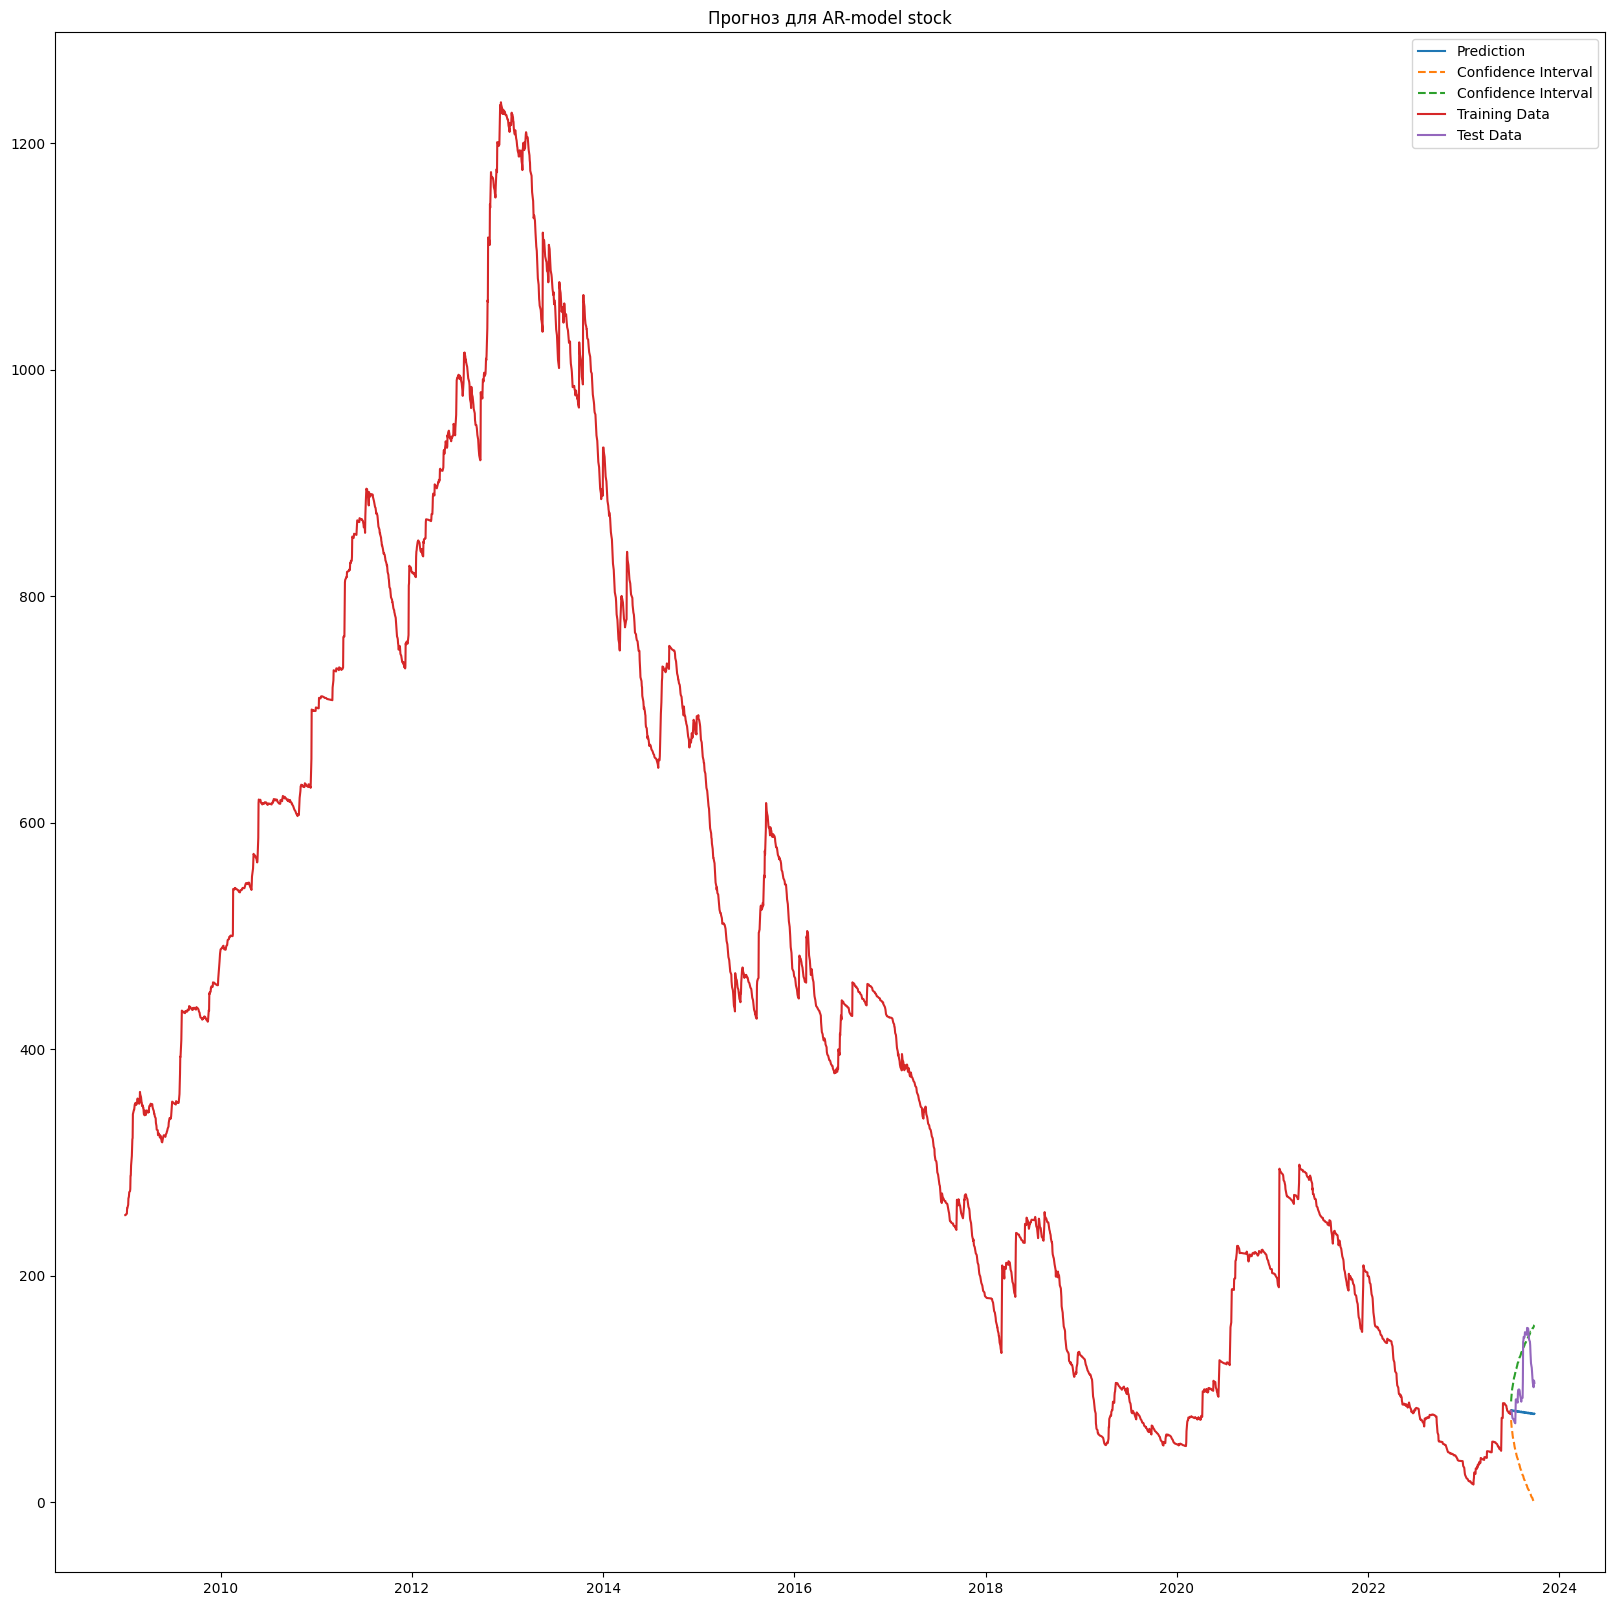

In [140]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

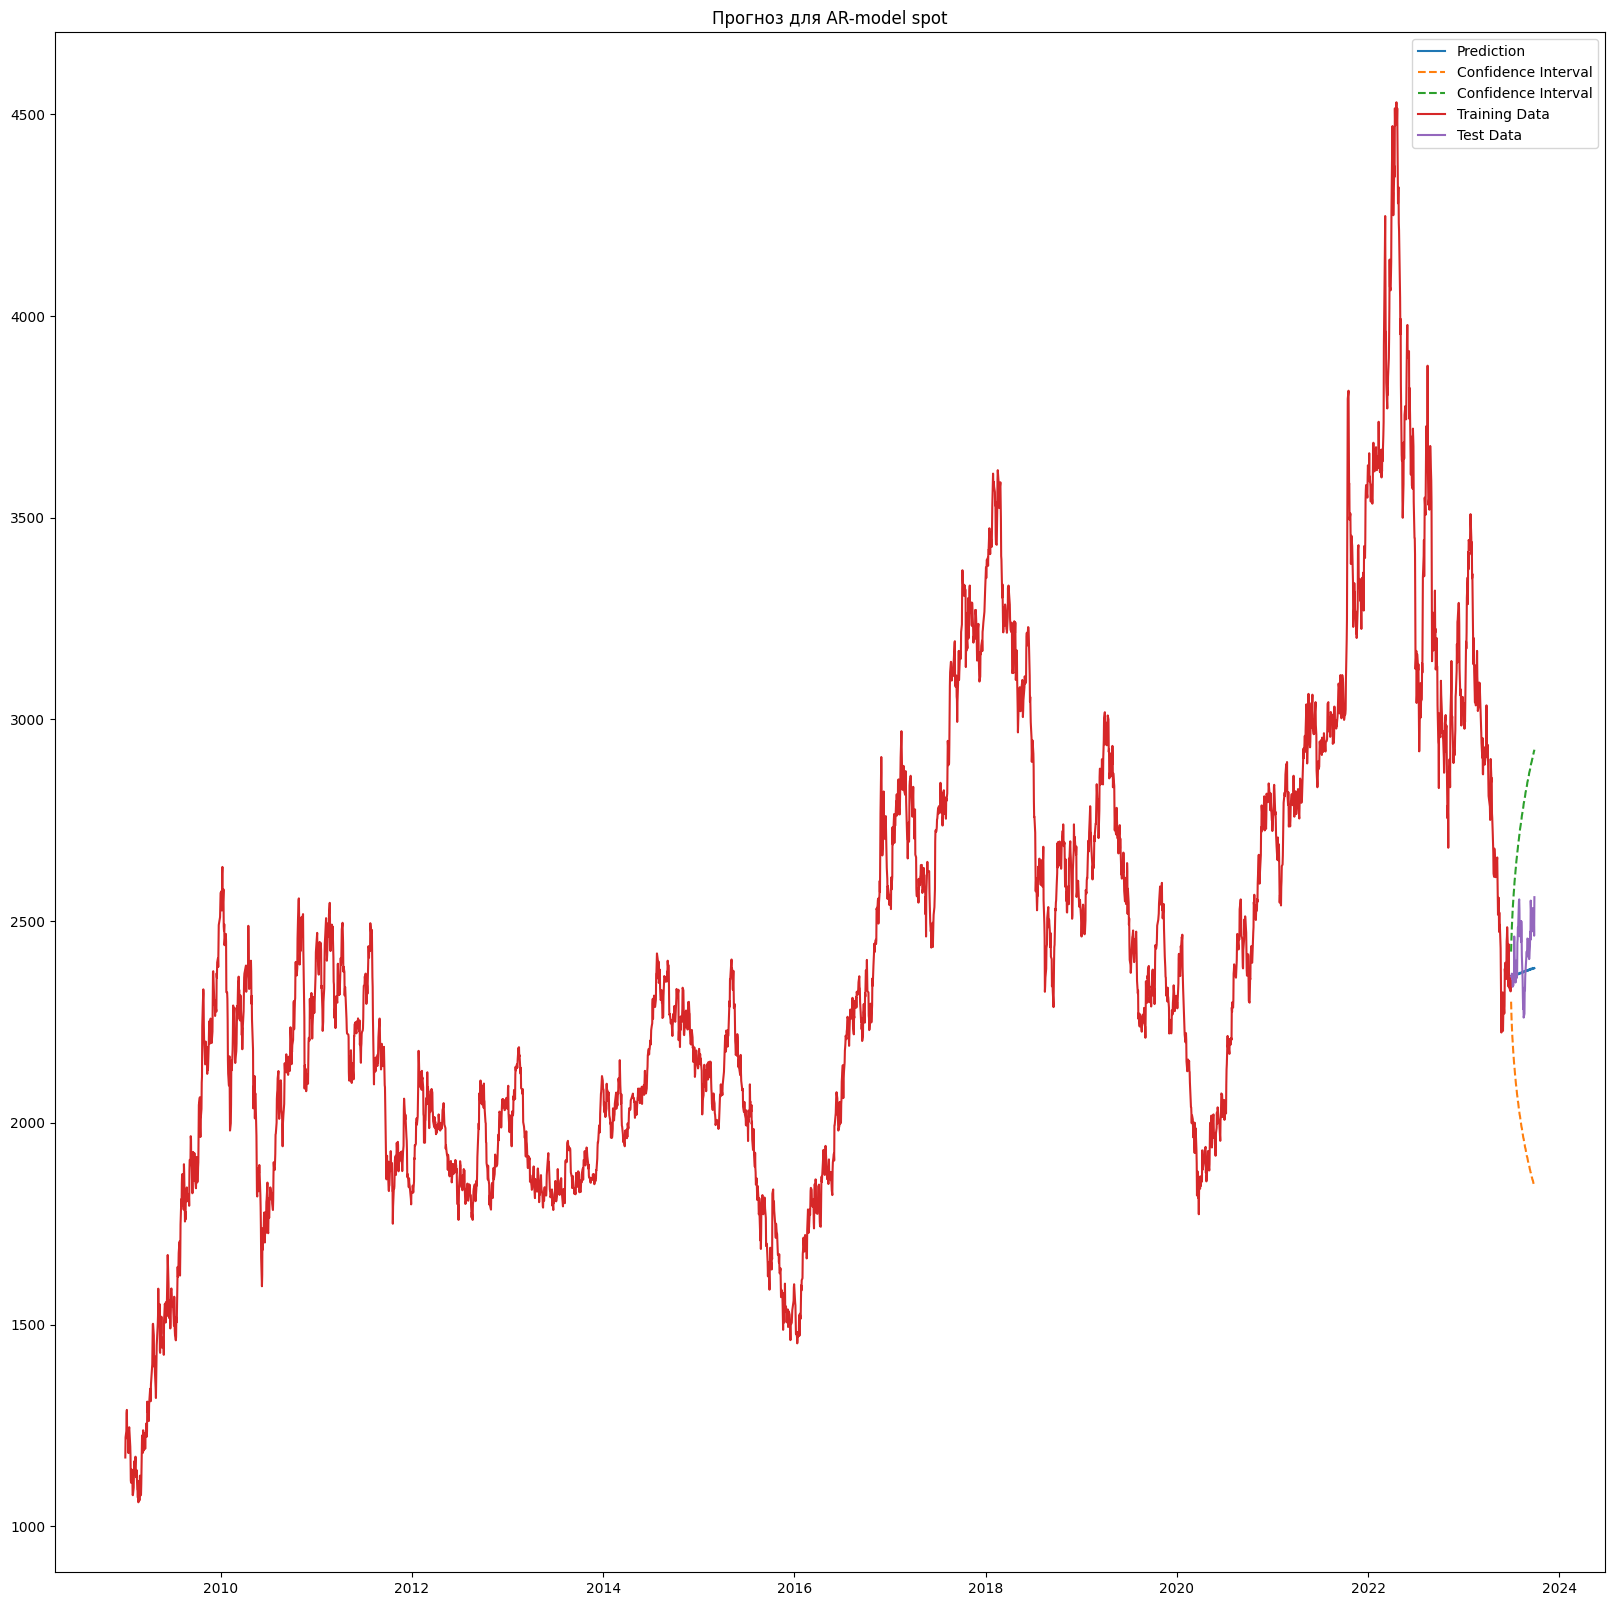

In [141]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_ar_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> Вывод: Весьма неожиданный результат для базовой модели спотовой цены (для нас это таргет который мы и планируем спрогнозировать), с учетом того, что в бенчмарках консалтинговых и аналитических агенств допускается разброс в 300 долларов, мы получили значительно большую точность при больших остатках на декомпозиции и околонулевой обработке данных. Данной точности вполне хватило бы для легковестного бенчмарка для использования в работе

> Результат на запасах при этом показал вполне предсказуемый для baseline модели.

> Так же стоти отметить следующее:
 * Прогноз не уловил дисперисю
 * 95% доверительный интервал весьма широк
> Что говорит о вероято слабой прогностической способности в бою (если бы мы ставили целью прогноз именно запасов).

---

### ARIMA прогноз (т.к. ряды изначально не стационарны их порядок дифференцирования равен 1, d=1)

In [142]:
# Используем модель ARIMA
arima_model_stock = ARIMA(train_stock, order=(p_stock, d_stock, q_stock)).fit()
arima_model_spot = ARIMA(train_spot, order=(p_spot, d_stock, q_stock)).fit()

# Прогноз
pred_arima_stock = arima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_arima_spot = arima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Модификация прогноза
pred_arima_stock = pred_arima_stock + stock_seasonal_mod + stock_resid_mod

pred_arima_spot = pred_arima_spot + spot_seasonal_mod + spot_resid_mod

# Доверительные интервалы
forecast_stock = arima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = arima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

In [143]:
# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_arima_stock, name='ARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_arima_spot, name='ARIMA-spot'))

RMSE для ARIMA-stock: 38.465
MAE для ARIMA-stock: 29.659
MAPE для ARIMA-stock: 23.3%


RMSE для ARIMA-spot: 94.375
MAE для ARIMA-spot: 75.798
MAPE для ARIMA-spot: 3.1%




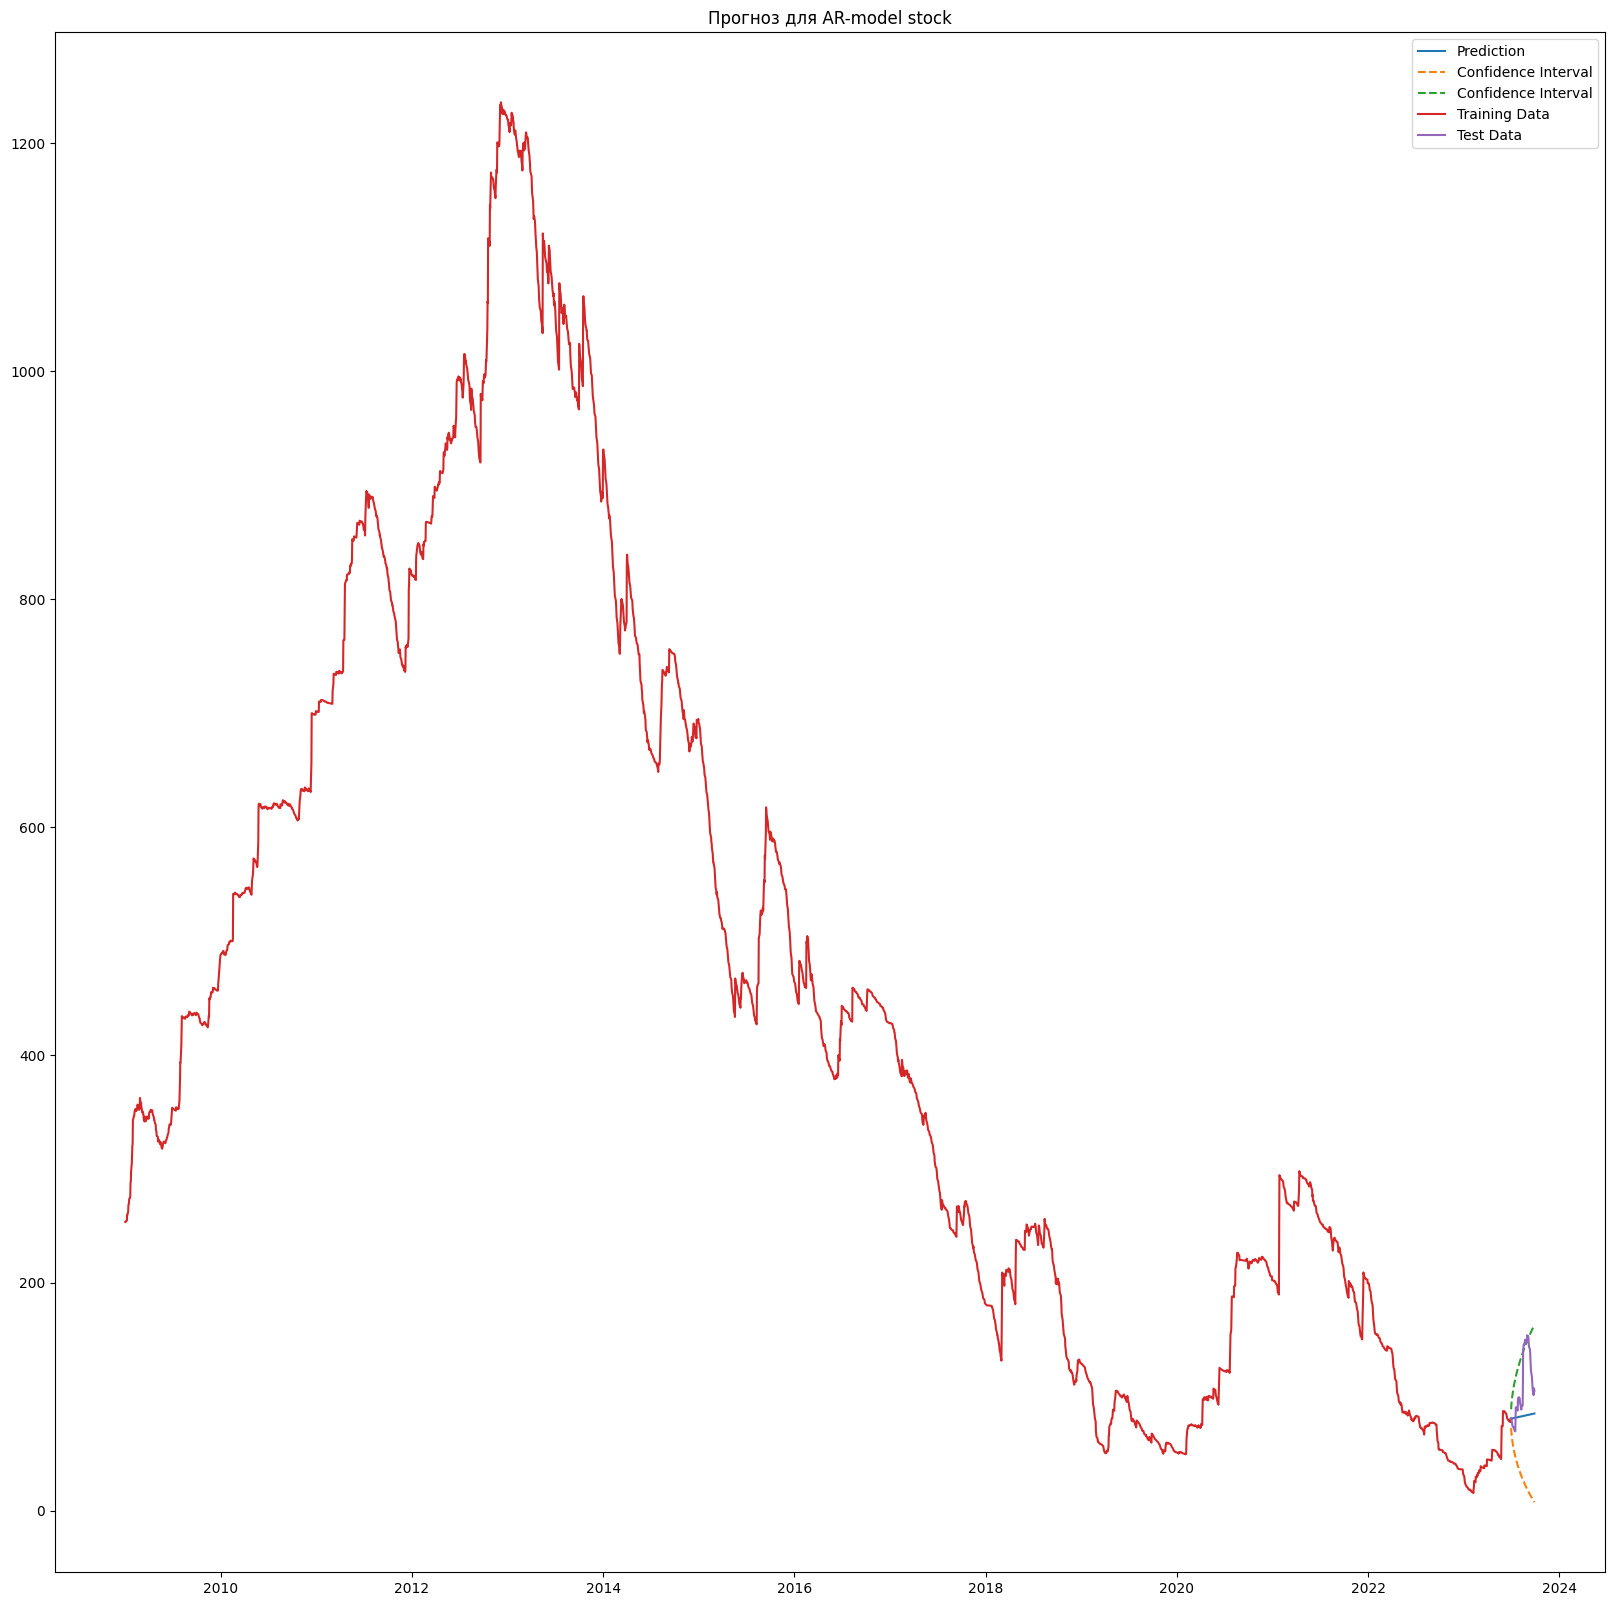

In [144]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_stock, conf_stock,
    train_stock, test_stock, name='AR-model stock'
)

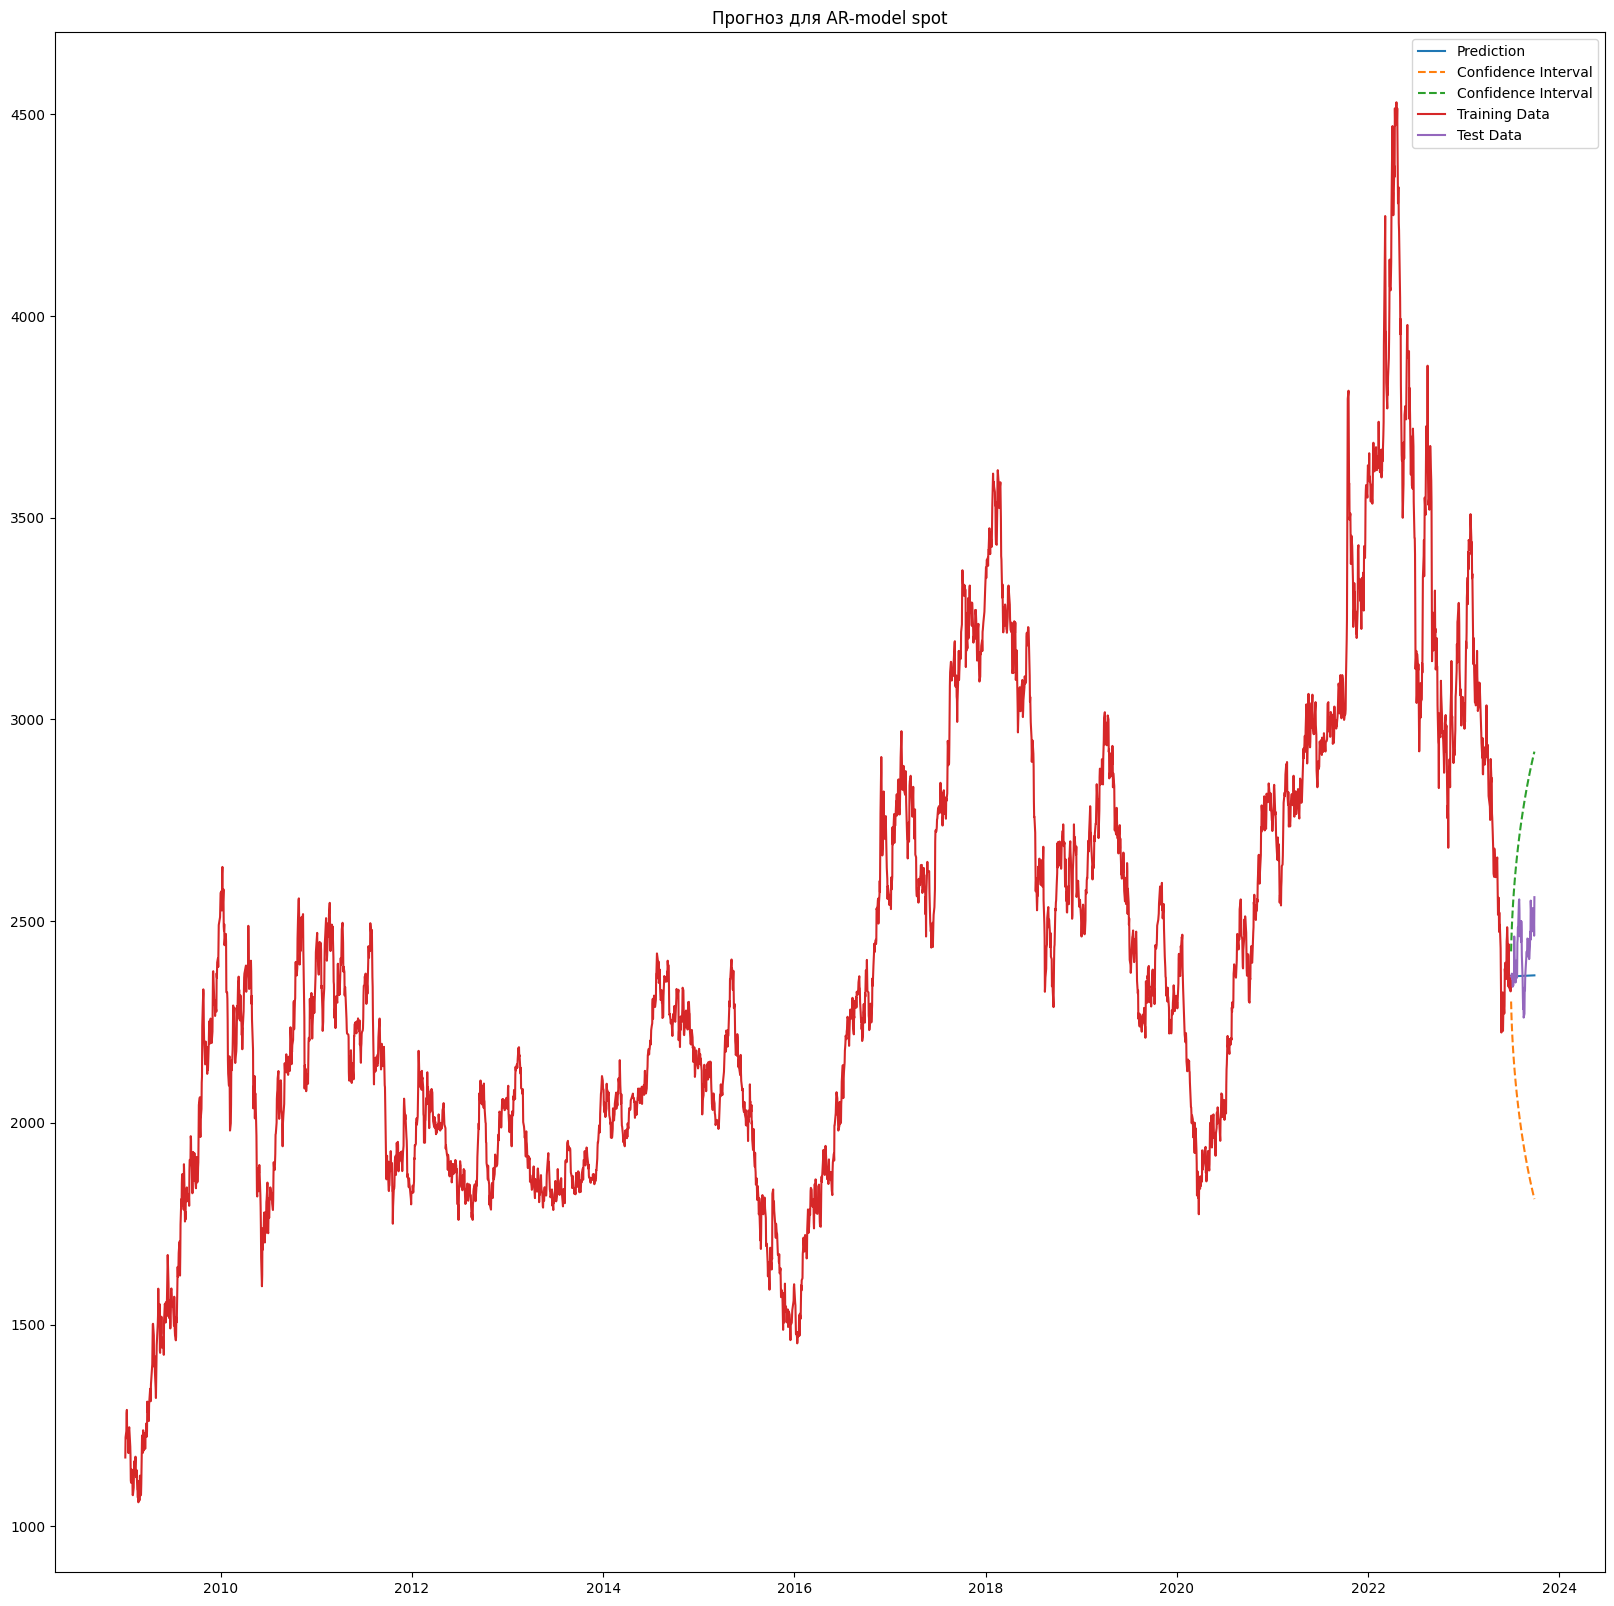

In [145]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_arima_spot, conf_spot,
    train_spot, test_spot, name='AR-model spot'
)

> В сравнение с baseline моделью произошло незначительное падение метрики spot-price, и незначительное увеличение stocks, графики так же отражают весьма сомнительную прогностическую способность для дневного анализа, НО, и это важно подчеркнуть, так как нашей задачей является СРЕДНЯЯ ЦЕНА за тестовый период, можно сказать, что задача, исходя из проделанного на данный момент анализа, вполне достижима

> Так же отсутсвует чувствительность по дисеперсии и гигантские доверительные интервалы.

---

### PMDARIMA прогноз, попробуем подобрать внутренние параметры модели автоматом.

In [146]:
model_stock = pm.auto_arima(
    train_stock, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_stock.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=2.09 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=33522.022, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=32095.196, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.70 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=33381.246, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=31451.974, Time=1.11 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.68 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.29 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=31587.011, Time=0.95 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=31440.544, Time=1.33 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=32077.132, Time=0.81 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.91 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=3.23 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=31436.804, Time=1.53 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=32074.583, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5294
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -15712.402
Date:                           Fri, 29 Sep 2023   AIC                          31436.804
Time:                                   08:44:26   BIC                          31476.241
Sample:                               01-01-2009   HQIC                         31450.587
                                    - 06-30-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1502      0.006     27.230      0.000       0.139       0.161
ar.L2          0.0455      0.010      4.560      0.000       0.026       0.065
ar.L3          0.0330      0.018      1.832      0.067      -0.002       0.068
ar.S.L7       -0.6243      0.003   -188.002      0.000      -0.631      -0.618
ar.S.L14      -0.3377      0.003   -100.720      0.000      -0.344      -0.331
sigma2        22.3401      0.063    353.653      0.000      22.216      22.464
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1988486.14
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             5.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        97.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [147]:
model_spot = pm.auto_arima(
    train_spot, start_p=1, start_q=1,
    test='adf',
    max_p=20, max_q=20, m=7,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
model_spot.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.82 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=55280.063, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=53644.598, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.71 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=55245.585, Time=0.14 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=53106.017, Time=1.57 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.08 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=53133.705, Time=0.62 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=53081.504, Time=1.69 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=53620.154, Time=1.01 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.84 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=2.61 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=53083.473, Time=2.03 sec
 ARIMA(2,1,1)(2,1,0)[7]             : AIC=53083.469, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5294
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -26535.752
Date:                           Fri, 29 Sep 2023   AIC                          53081.504
Time:                                   08:45:05   BIC                          53114.369
Sample:                               01-01-2009   HQIC                         53092.990
                                    - 06-30-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0695      0.009      7.852      0.000       0.052       0.087
ar.L2          0.0709      0.010      7.098      0.000       0.051       0.090
ar.S.L7       -0.6745      0.008    -84.779      0.000      -0.690      -0.659
ar.S.L14      -0.3127      0.008    -37.099      0.000      -0.329      -0.296
sigma2      1341.3978     14.255     94.100      0.000    1313.458    1369.337
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5124.73
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
model_stock.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [149]:
with open('./data/ar_stock_zn.pkl', 'wb') as pkl_file:
    pickle.dump(model_stock.get_params(), pkl_file)

In [150]:
model_spot.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (2, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (2, 1, 0, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [151]:
with open('./data/ar_spot_zn.pkl', 'wb') as pkl_file:
    pickle.dump(model_spot.get_params(), pkl_file)

---

#### До этого момента я не сравнивал модели по критерию AIC ввиду того что по итогу все равно бы начал перебирать внутренние параметры для последующего использования SARIMAX


### ARIMA - по подобранным параметрам

In [152]:
order_stock = model_stock.order
seasonal_order_stock = model_stock.seasonal_order

order_spot = model_spot.order
seasonal_order_spot = model_spot.seasonal_order

In [153]:
# Используем модель ARIMA
pmarima_model_stock = ARIMA(
    train_stock, order=order_stock,
    seasonal_order=seasonal_order_stock).fit()

pmarima_model_spot = ARIMA(
    train_spot, order=order_spot,
    seasonal_order=seasonal_order_spot).fit()

# Прогноз
pred_pmarima_stock = pmarima_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_pmarima_spot = pmarima_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Доверительные интервалы
forecast_stock = pmarima_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = pmarima_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)

# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_pmarima_stock, name='PMARIMA-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_pmarima_spot, name='PMARIMA-spot'))

RMSE для PMARIMA-stock: 42.619
MAE для PMARIMA-stock: 33.494
MAPE для PMARIMA-stock: 26.400000000000002%


RMSE для PMARIMA-spot: 282.71
MAE для PMARIMA-spot: 241.757
MAPE для PMARIMA-spot: 9.8%




> Ухудшение метрик, усложнение можели не идет на пользу.

---

### SARIMAX

In [154]:
# Инициализация модели
sarimax_model_stock = SARIMAX(
    train_stock, order=order_stock, seasonal_order=seasonal_order_stock).fit()

sarimax_model_spot = SARIMAX(
    train_spot, order=order_spot, seasonal_order=seasonal_order_spot).fit()

# Спрогнозируем
pred_sarimax_stock = sarimax_model_stock.predict(
    start=len(train_stock), end=len(train_stock)+len(test_stock)-1)

pred_sarimax_spot = sarimax_model_spot.predict(
    start=len(train_spot), end=len(train_spot)+len(test_spot)-1)

# Построим доверительные интервалы
forecast_stock = sarimax_model_stock.get_forecast(steps=len(test_stock))
conf_stock = forecast_stock.conf_int(alpha=0.05)

forecast_spot = sarimax_model_spot.get_forecast(steps=len(test_spot))
conf_spot = forecast_spot.conf_int(alpha=0.05)


# Оценим метрики и залогируем результаты
log_metrics_stock(metrics_calculation(
    test_stock, pred_sarimax_stock, name='SARIMAX-stock'))
log_metrics_spot(metrics_calculation(
    test_spot, pred_sarimax_spot, name='SARIMAX-spot'))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99803D+00    |proj g|=  5.40618D-02


 This problem is unconstrained.



At iterate    5    f=  2.96796D+00    |proj g|=  8.67375D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      7      9      1     0     0   5.622D-06   2.968D+00
  F =   2.9679641182625862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.04915D+00    |proj g|=  1.40210D-02


 This problem is unconstrained.



At iterate    5    f=  5.02660D+00    |proj g|=  8.46501D-02

At iterate   10    f=  5.01242D+00    |proj g|=  1.40906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.376D-06   5.012D+00
  F =   5.0124201381769637     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RMSE для SARIMAX-stock: 42.619
MAE для SARIMAX-stock: 33.494
MAPE для SARIMAX-stock: 26.400000000000002%


RMSE для SARIMAX-spot: 282.71
MAE для SARIMAX-spot: 241.757
MAPE для SARIMAX-spot: 9.8%




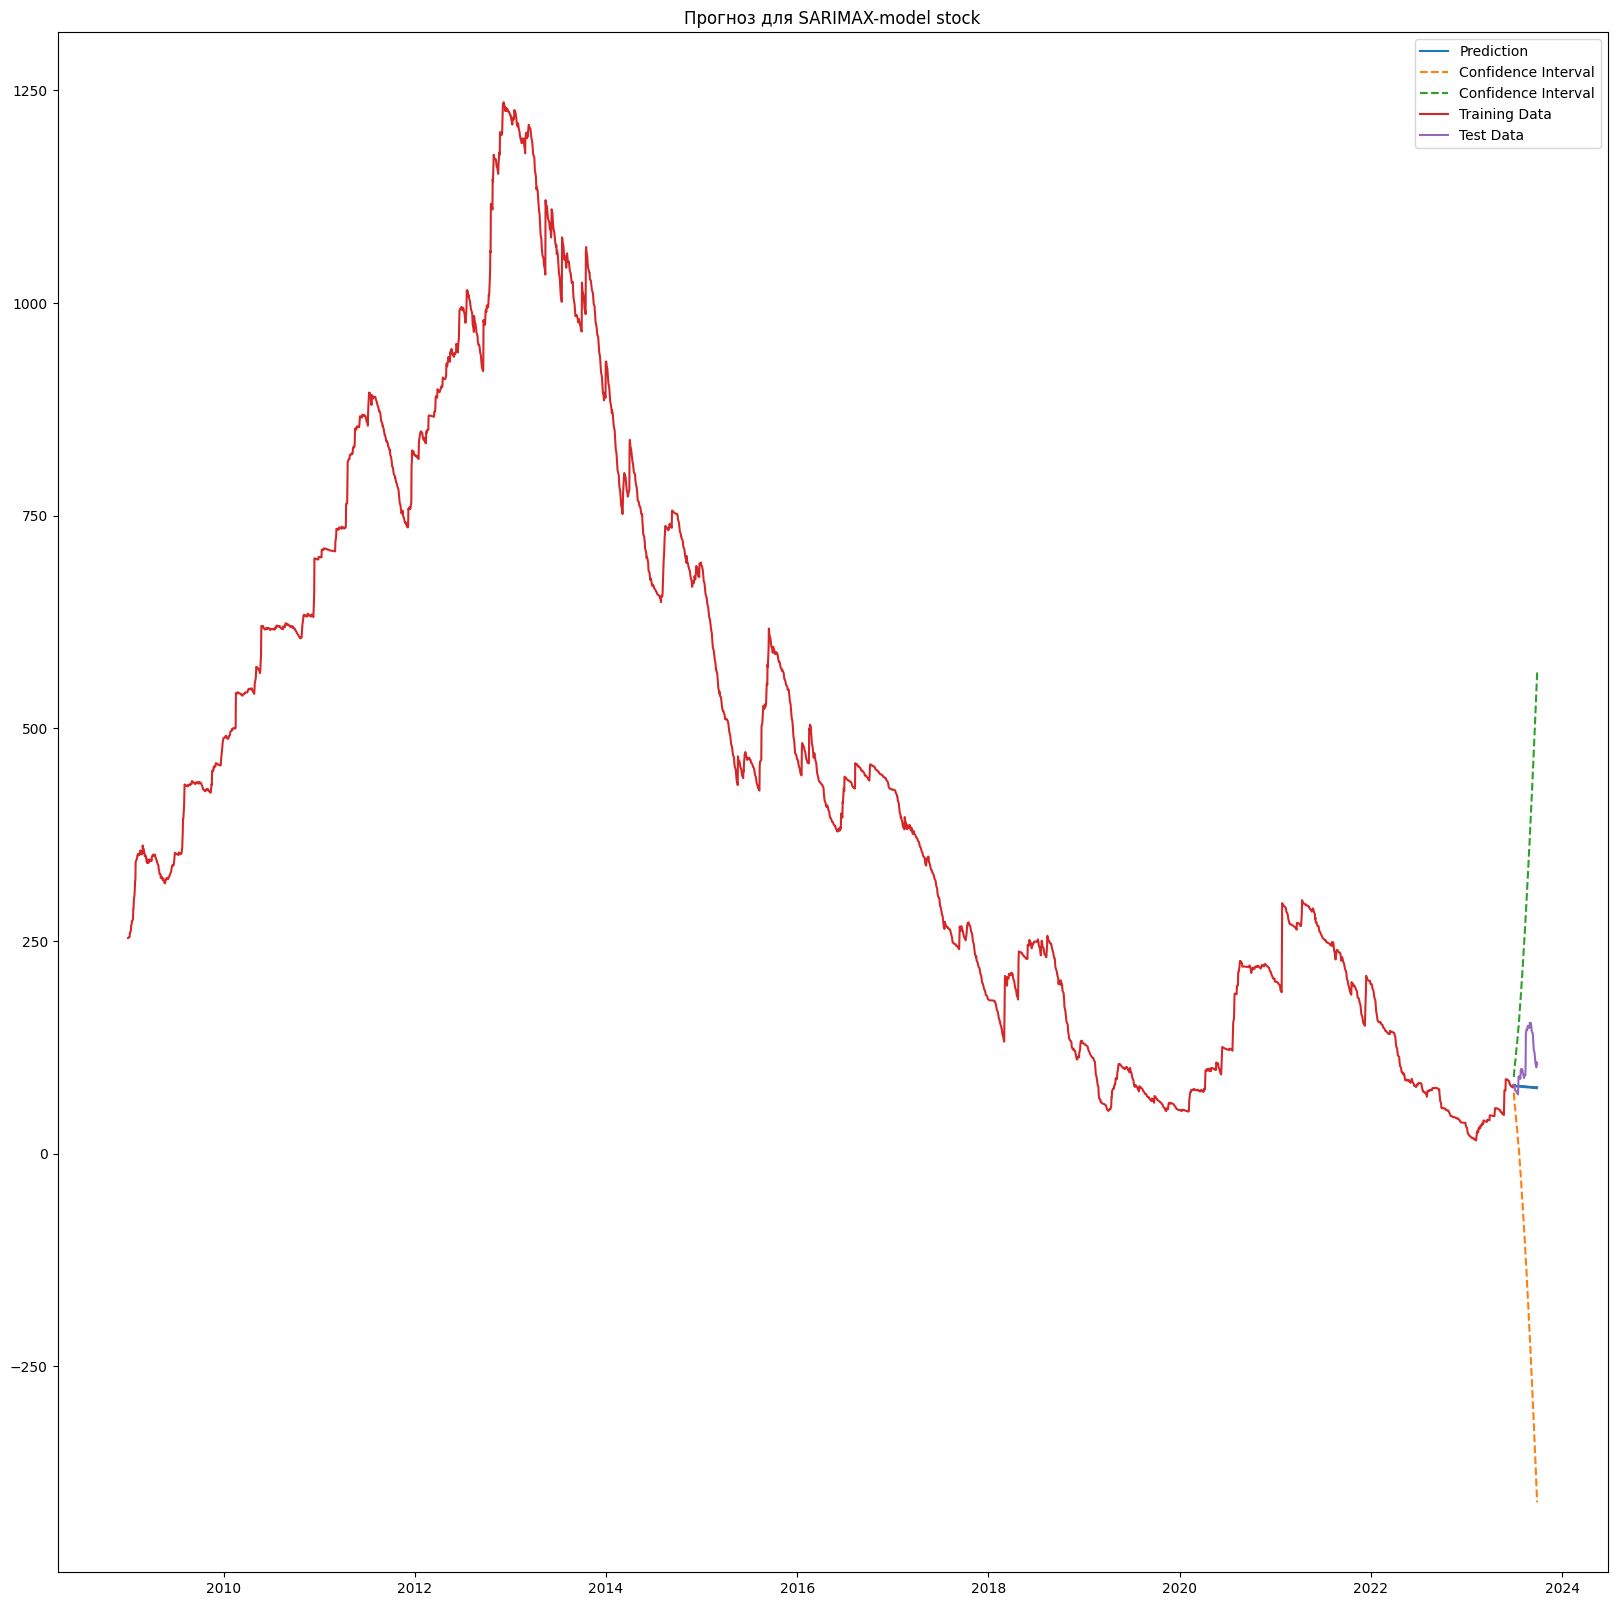

In [155]:
# Выведем график прогноза с доверительными интервалами
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_stock, conf_stock,
    train_stock, test_stock, name='SARIMAX-model stock'
)

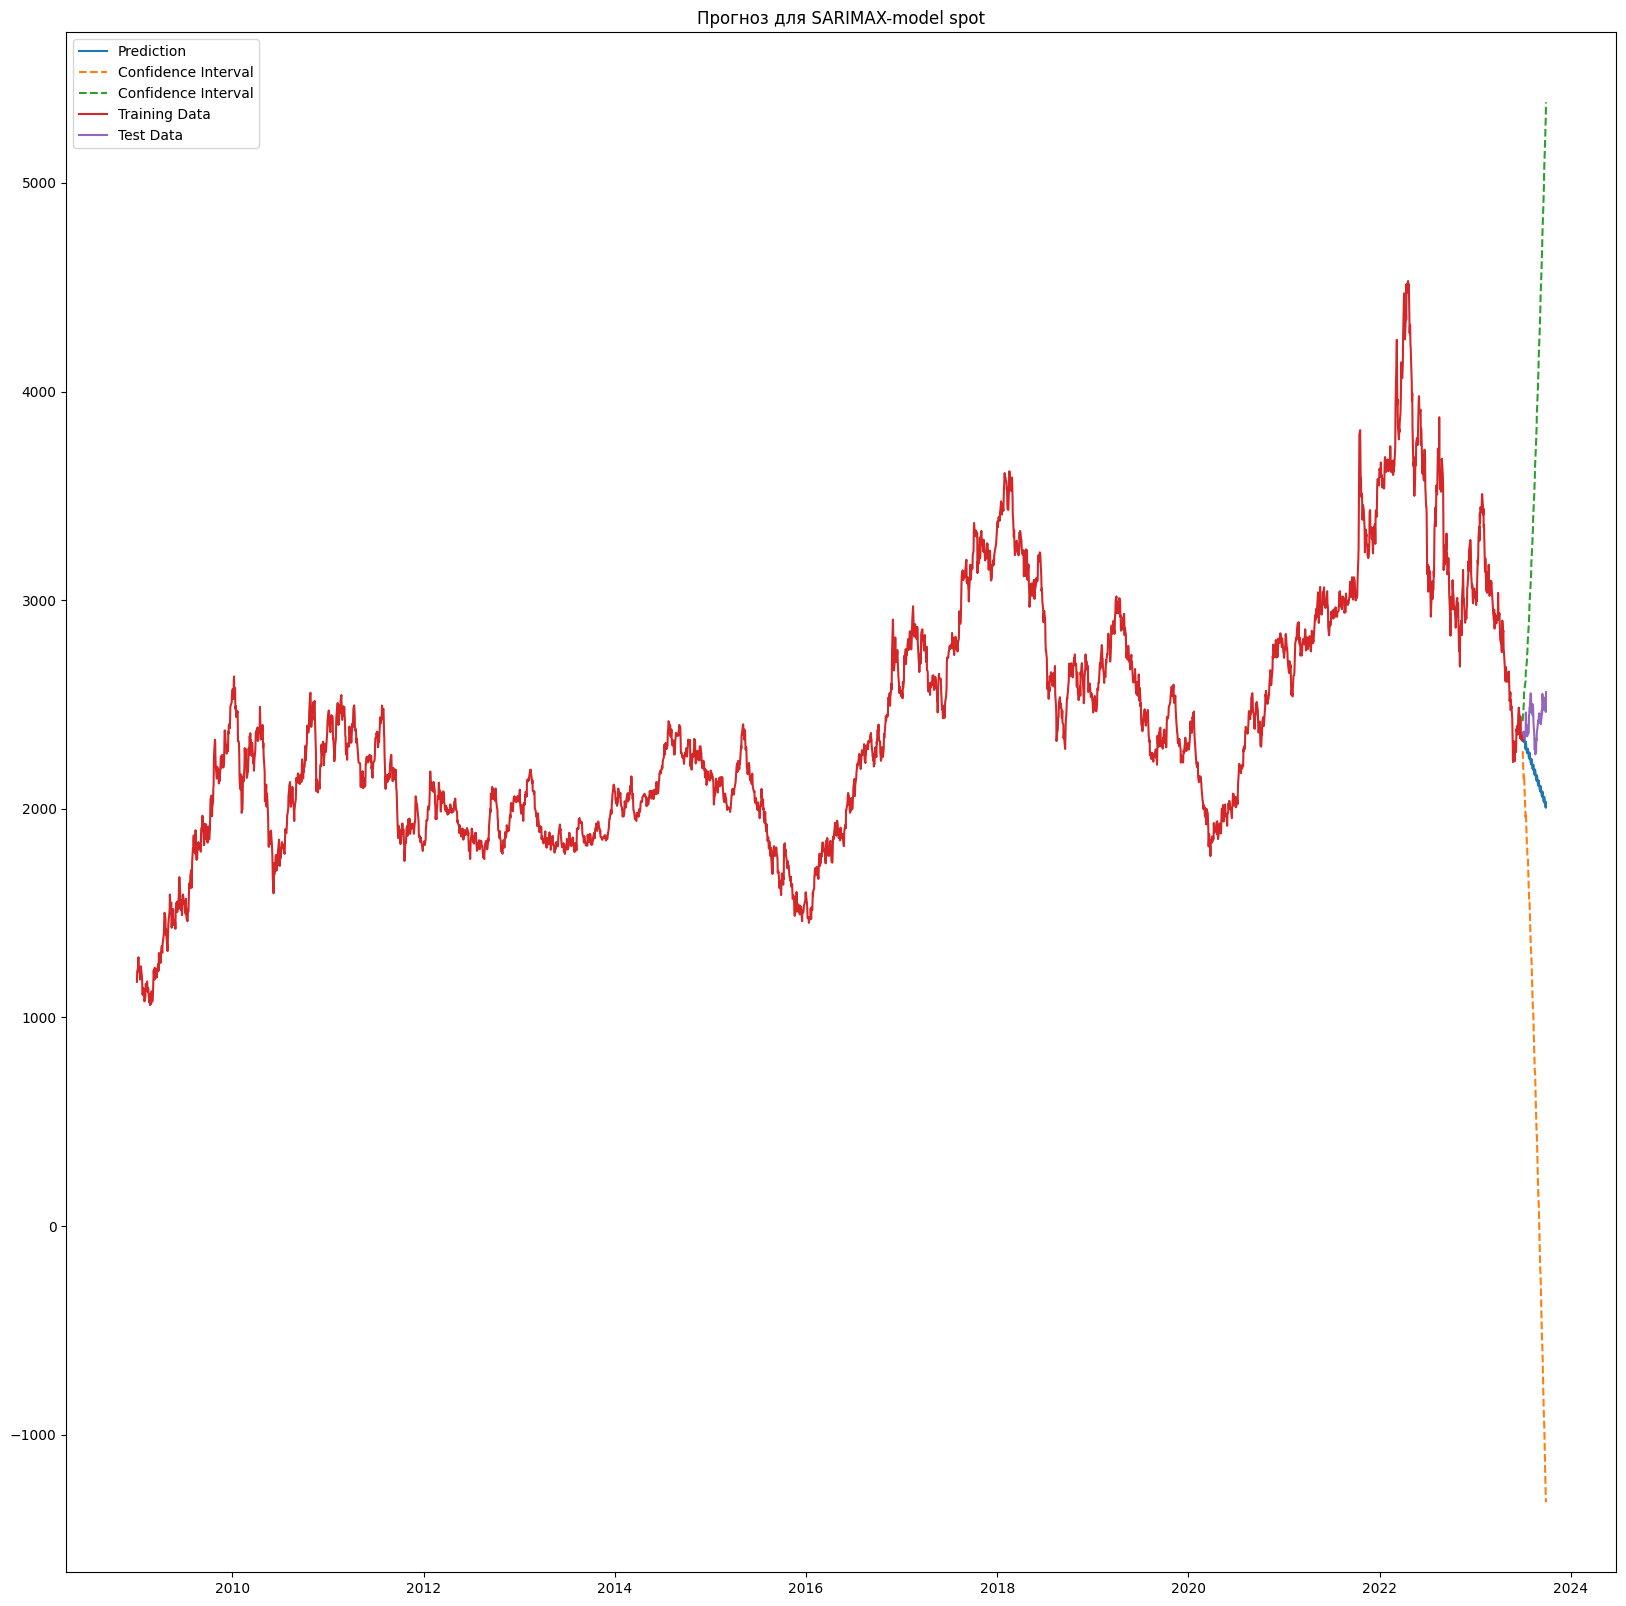

In [156]:
fig = plt.figure(figsize=(20, 20))
visualisation_prog(
    pred_sarimax_spot, conf_spot,
    train_spot, test_spot, name='SARIMAX-model spot'
)

> Вывод: SARIMAX показал наихудшие результаты, возможно причина заключается в интерполированных данных, либо же влиянии экзогенных факторов не учитываемых в данном анализе (напоминаю нам необходимо разработать легковесный бенчмарк для LME для расчета среднеквартальной цены)

---

### GARCH прогноз для гетероскедастичного ряда.

In [157]:
# Инициализируем модель
garch_stock = arch_model(
    train_stock, lags=1, vol='GARCH',
    p=1, q=1, rescale=True).fit()

garch_spot = arch_model(
    train_spot, lags=1, vol='GARCH',
    p=2, q=1, rescale=True).fit()

# Сделаем предсказание
pred_garch_stock = garch_stock.forecast(
    start=str(train_stock.index[-1]), horizon=90)
pred_garch_spot = garch_spot.forecast(
    start=str(train_spot.index[-1]), horizon=90)

forecast_values = pred_garch_spot.mean.values[-1, :]
for i in range(len(test_spot)):
    print(
        f"Фактическое значение: {test_spot[i]}, Прогнозное значение: {forecast_values[i]}")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4870263.638736223
Iteration:      2,   Func. Count:     12,   Neg. LLF: 28467.614348236522
Iteration:      3,   Func. Count:     18,   Neg. LLF: 34354.020079753405
Iteration:      4,   Func. Count:     25,   Neg. LLF: 23501.267632305855
Iteration:      5,   Func. Count:     31,   Neg. LLF: 22871.591003916266
Iteration:      6,   Func. Count:     36,   Neg. LLF: 23282.479800816887
Iteration:      7,   Func. Count:     48,   Neg. LLF: 22785.956823845147
Iteration:      8,   Func. Count:     55,   Neg. LLF: 22594.660225107178
Iteration:      9,   Func. Count:     61,   Neg. LLF: 22635.177544310085
Iteration:     10,   Func. Count:     68,   Neg. LLF: 22557.84304346043
Iteration:     11,   Func. Count:     73,   Neg. LLF: 22557.223623710175
Iteration:     12,   Func. Count:     78,   Neg. LLF: 22553.87457728126
Iteration:     13,   Func. Count:     83,   Neg. LLF: 22550.95132828958
Iteration:     14,   Func. Count:     88,   Neg. LLF: 2

> В будущем нам пригодится SARIMAX, хоть сама модель и не подошла, но мы будем прогнозировать дисперсию и накладывать на результаты прогноза спота и запасов.

---

### Перед тем как перейти кследующей части, произведем небольшую манипуляцию с данными для проверки модели с включением экзогенных факторов (для нас это фьючерсы).

In [158]:
# Посмотрим на картины прогнозов для моделей показавших лучший результат
# с использованием авторегрессии
display(pred_ar_stock.tail(15), pred_arima_stock.tail(15))

2023-09-14    78.686675
2023-09-15    78.169618
2023-09-16    78.143425
2023-09-17    78.117233
2023-09-18    78.091040
2023-09-19    78.360605
2023-09-20    78.685688
2023-09-21    78.445222
2023-09-22    77.928164
2023-09-23    77.901970
2023-09-24    77.875776
2023-09-25    77.849582
2023-09-26    78.119145
2023-09-27    78.444227
2023-09-28    78.203760
Freq: D, dtype: float64

2023-09-14    84.685682
2023-09-15    84.736214
2023-09-16    84.786739
2023-09-17    84.837257
2023-09-18    84.887768
2023-09-19    84.938272
2023-09-20    84.988769
2023-09-21    85.039260
2023-09-22    85.089743
2023-09-23    85.140220
2023-09-24    85.190689
2023-09-25    85.241152
2023-09-26    85.291608
2023-09-27    85.342057
2023-09-28    85.392500
Freq: D, dtype: float64

In [159]:
# Выбираем модель для прогноза остатков, тут стоит отметить почему
# выбор пал на базовую модель, дело в том, что различие в метриках
# было не значительно, но сама картина прогнозных запасов выглядит
# реалистичнее ()
best_ts = pred_ar_stock

In [160]:
# Объединим тренировочную выборку по запасам с предсказанием в единый вектор
stock_column = pd.concat([train_stock, best_ts])
stock_column.tail(10)

2023-09-19    78.360605
2023-09-20    78.685688
2023-09-21    78.445222
2023-09-22    77.928164
2023-09-23    77.901970
2023-09-24    77.875776
2023-09-25    77.849582
2023-09-26    78.119145
2023-09-27    78.444227
2023-09-28    78.203760
dtype: float64

In [161]:
# Создадим новую рабочую выборку, она нам понадобится и на этом этапе и для дальнейшего исследования.
working_data_new = pd.concat(
    [working_data[[working_data.columns.to_list()[0], working_data.columns.to_list()[
        1]]], stock_column],
    axis=1).rename(columns={0: working_data.columns.to_list()[2]})

display(working_data.head(), working_data.tail())

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2009-01-01,1170.500000,1580.000000,253.4875
2009-01-02,1220.500000,1568.333333,253.4750
2009-01-03,1225.666667,1556.666667,253.8250
2009-01-04,1230.833333,1545.000000,254.1750
2009-01-05,1236.000000,1536.000000,254.5250


,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-09-24,2513.5,2346.0,102.833333
2023-09-25,2504.0,2376.0,101.550000
2023-09-26,2508.0,2356.0,107.525000
2023-09-27,2464.0,2334.5,107.075000
2023-09-28,2559.5,2375.0,105.375000


In [162]:
# Сформируем трейн/тест для общего случая
train = working_data_new[:len(train_spot)]
test = working_data_new[-len(test_spot):]

In [163]:
# Тренировочная эндогенная
endog_train = train.iloc[:, 0]
# Небольшой пердолинг для экзогенных
exog_train = train.iloc[:, 1:]
exog_test = test.iloc[:, 1:]
# exog_train = pd.concat([exog_train, exog_test], axis=0)

# Тестовая выборка
endog_test = test.iloc[:, 0]

# Горизонт планирования
start = str(endog_test.index.min())
end = str(endog_test.index.max())

In [164]:
# Инициализируем модель, порядок p,d,q возьмем из предлагаемых pdarima
arimax_model_spot = ARIMA(endog_train, exog=exog_train, order=order_spot).fit()

In [165]:
# Спрогнозируем
pred_arimax_spot = arimax_model_spot.predict(
    start=start, end=end, exog=exog_test)

In [166]:
log_metrics_spot(metrics_calculation(
    pred_arimax_spot, endog_test, name='ARIMAX-spot'))

RMSE для ARIMAX-spot: 85.938
MAE для ARIMAX-spot: 69.161
MAPE для ARIMAX-spot: 2.9000000000000004%




> Хуже чем baseline.

----

### Попробуем методы МО в контексте прогноза запасов

In [167]:
# Реинициализируем выборку
working_data_ml = working_data.reset_index()

working_data_ml = working_data_ml.drop(
    columns=working_data_ml.columns.to_list()[1])

working_data_ml['date'] = working_data_ml['date'].apply(date_format_reverse)

# Сформируем трейн/тест для общего случая
train_ml = working_data_ml[:len(train_spot)]
test_ml = working_data_ml[-len(test_spot):]

# Разобьем на обучающую/тестовую подвыборки
X_train_ml = train_ml.iloc[:, :2]
y_train_ml = train_ml.iloc[:, 2]

X_test_ml = test_ml.iloc[:, :2]
y_test_ml = test_ml.iloc[:, 2]

---

#### Linear Regression

In [168]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model_ml = LinearRegression(
    n_jobs=-1
)

lr_model_ml.fit(X_train_ml, y_train_ml)

pred_lr_model_ml = lr_model_ml.predict(X_test_ml)
pred_lr_model_ml = pd.Series(pred_lr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_lr_model_ml, name='LR-model'))

RMSE для LR-model: 65.544
MAE для LR-model: 59.112
MAPE для LR-model: 50.5%




> Хуже baseline.

---

#### Decision Tree regressor for stock

In [169]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_ml = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_ml.fit(X_train_ml, y_train_ml)
grid_search_dt_ml.best_params_

# Modeling
dt_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)
dt_model.fit(X_train_ml, y_train_ml)

pred_dt_spot_ml = dt_model.predict(X_test_ml)
pred_dt_spot_ml = pd.Series(pred_dt_spot_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_dt_spot_ml, name='DT-model'))

RMSE для DT-model: 41.371
MAE для DT-model: 32.34
MAPE для DT-model: 25.4%




> Незначительно лучше baseline.

---

#### RandomForestRegressor для stock.

In [170]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr_ml = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr_ml.fit(X_train_ml, y_train_ml)
grid_search_rfr_ml.best_params_

# Modelling
rfr_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

rfr_model.fit(X_train_ml, y_train_ml)

pred_rfr_model_ml = rfr_model.predict(X_test_ml)
pred_rfr_model_ml = pd.Series(pred_rfr_model_ml, index=test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_rfr_model_ml, name='RFR-model'))

RMSE для RFR-model: 41.427
MAE для RFR-model: 32.394
MAPE для RFR-model: 25.5%




> Хуже baseline.

----

### Gradient_boost stock

In [171]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr_ml = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr_ml.fit(X_train_ml, y_train_ml)
grid_search_gbr_ml.best_params_

# Modelling
gbr_model_ml = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)

gbr_model_ml.fit(X_train_ml, y_train_ml)

pred_gbr_model_ml = gbr_model_ml.predict(X_test_ml)
pred_gbr_model_ml = pd.Series(pred_gbr_model_ml, test.index)

log_metrics_stock(metrics_calculation(
    y_test_ml, pred_gbr_model_ml, name='GBR-model_full'))

RMSE для GBR-model_full: 34.328
MAE для GBR-model_full: 26.903
MAPE для GBR-model_full: 21.3%




> Хуже baseline.

---

### Stacking

In [172]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt_ml.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_rfr_ml.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr_ml.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor_ml = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor_ml.fit(X_train_ml, y_train_ml)

# Получаем предсказания
predictions_ml = stacking_regressor_ml.predict(X_test_ml)

log_metrics_stock(metrics_calculation(
    y_test_ml, predictions_ml, name='Stacking'))

RMSE для Stacking: 26.303
MAE для Stacking: 22.065
MAPE для Stacking: 19.2%




> Хуже baseline.

---

### Посмотрим на результаты моделирования запасов

In [173]:
pd.read_csv('./data/errors/stock_zink.csv').sort_values(by='mae')

,date,model_name,rmse,mae,mape
8,2023-09-26 00:00:00,Stacking,18.984,16.049,14.7
17,2023-09-27 00:00:00,Stacking,22.899,18.753,16.3
26,2023-09-28 00:00:00,Stacking,22.777,19.653,17.4
35,2023-09-29 00:00:00,Stacking,26.303,22.065,19.2
25,2023-09-28 00:00:00,GBR-model_full,34.592,26.888,21.2
34,2023-09-29 00:00:00,GBR-model_full,34.328,26.903,21.3
7,2023-09-26 00:00:00,GBR-model_full,34.750,27.071,21.4
16,2023-09-27 00:00:00,GBR-model_full,36.368,28.254,22.2
19,2023-09-28 00:00:00,ARIMA-stock,38.302,29.354,23.0
28,2023-09-29 00:00:00,ARIMA-stock,38.465,29.659,23.3


> Вывод: Несмотря на небольшое превосходство дерева решений, был принят выбор в сторону AR-baseline в виду того, что:
> 1. Запасы имеют низкую корреляцию с целевой переменной, а следовательно точность их прогнозирования не значительно повлияет на финальный результат.
> 2. При моделировании запасов через дерево, мы опираемся на факторы, которые (spoiler) в последствии будут участвовать в прогнозах цен, что может привнести шум в прогноз.

---

## Часть 2.

#### В данной части мы возьмем модель предсказашую наилучший результат (на рассматриваемых метриках) для остатках запасов, затем используем вектор предсказания как фиты для моделей линейной регрессии, сравним с тестовой выборкой и оценим результат с лучшим результатом для прогноза спотовой цены полученного с помощью анализа временных рядов.

In [174]:
exp_train = train.reset_index(names='date')
exp_test = test.reset_index(names='date')

exp_train['date'] = exp_train['date'].apply(date_format_reverse)
exp_test['date'] = exp_test['date'].apply(date_format_reverse)

In [175]:
# Сформируем трейн/тест для спота
X_train = exp_train.drop(exp_train.columns.tolist()[1], axis=1)
y_train = exp_train[exp_train.columns.tolist()[1]]

X_test = exp_test.drop(exp_test.columns.tolist()[1], axis=1)
y_test = exp_test[exp_test.columns.tolist()[1]]

---

#### Linear Regression

In [176]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
lr_model = LinearRegression(
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

pred_lr_model = lr_model.predict(X_test)
pred_lr_model = pd.Series(pred_lr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_lr_model, name='LR-model'))

RMSE для LR-model: 310.809
MAE для LR-model: 260.138
MAPE для LR-model: 10.9%




> Хуже baseline.

---

#### Decision Tree regressor

In [177]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [178]:
dt_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

# Законсервируем модель на будущее
with open('./data/decision_tree_zn.pkl', 'wb') as input:
    pickle.dump(dt_model, input)

dt_model.fit(X_train, y_train)

pred_dt_spot = dt_model.predict(X_test)
pred_dt_spot = pd.Series(pred_dt_spot, index=test.index)
log_metrics_spot(metrics_calculation(y_test, pred_dt_spot, name='DT-model'))

RMSE для DT-model: 441.269
MAE для DT-model: 342.343
MAPE для DT-model: 14.2%




> Хуже baseline, но лучшая из представленных ниже.

---

#### Decision Tree regressor (only futures)

In [179]:
param_grid = {
    'min_samples_leaf': [2, 3, 4, 5, 6],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

grid_search_dt_s = GridSearchCV(
    estimator=DecisionTreeRegressor(
        random_state=42
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_dt_s.fit(X_train.iloc[:, :-1], y_train)
grid_search_dt_s.best_params_

{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [180]:
dt_model_s = DecisionTreeRegressor(
    **grid_search_dt_s.best_params_,
    random_state=42
)
dt_model_s.fit(X_train.iloc[:, :-1], y_train)

pred_dt_spot_s = dt_model_s.predict(X_test.iloc[:, :-1])
pred_dt_spot_s = pd.Series(pred_dt_spot_s, index=test.index)
log_metrics_spot(metrics_calculation(
    y_test, pred_dt_spot_s, name='DT_simple-model'))

RMSE для DT_simple-model: 441.269
MAE для DT_simple-model: 342.343
MAPE для DT_simple-model: 14.2%




> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе только фючерсов.

In [181]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_srfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_srfr.fit(X_train.iloc[:, :2], y_train)
grid_search_srfr.best_params_

{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}

In [182]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
srfr_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

srfr_model.fit(X_train.iloc[:, :2], y_train)

pred_srfr_model = srfr_model.predict(X_test.iloc[:, :2])
pred_srfr_model = pd.Series(pred_srfr_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_srfr_model, name='RFR-model_no_stock'))

RMSE для RFR-model_no_stock: 390.313
MAE для RFR-model_no_stock: 313.913
MAPE для RFR-model_no_stock: 13.100000000000001%




> Хуже baseline.

---

#### RandomForestRegressor для spot-price на основе спрогнозированных запасов.

In [183]:
# Подберем оптимальные параметры через GridSearch с кроссвалидацией на 5 фолдах
scoring = [
    'neg_mean_absolute_percentage_error',
    'neg_mean_absolute_error',
    'neg_root_mean_squared_error'
]

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 7, 10]
}

grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_

{'max_depth': 3, 'min_samples_split': 7, 'n_estimators': 100}

In [184]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
rfr_model = RandomForestRegressor(
    **grid_search_rfr.best_params_,
    random_state=42,
)

rfr_model.fit(X_train, y_train)

pred_rfr_model = rfr_model.predict(X_test)
pred_rfr_model = pd.Series(pred_rfr_model, index=test.index)

log_metrics_spot(metrics_calculation(y_test, pred_rfr_model, name='RFR-model'))

RMSE для RFR-model: 384.686
MAE для RFR-model: 309.868
MAPE для RFR-model: 12.9%




> Хуже baseline.

----

### Gradient_boost stock + futures

In [185]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbr = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search_gbr.fit(X_train, y_train)
grid_search_gbr.best_params_

{'learning_rate': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [186]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)

gbr_model.fit(X_train, y_train)

pred_gbr_model = gbr_model.predict(X_test)
pred_gbr_model = pd.Series(pred_gbr_model, test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbr_model, name='GBR-model_full'))

RMSE для GBR-model_full: 162.567
MAE для GBR-model_full: 120.881
MAPE для GBR-model_full: 4.9%




> Хуже baseline.

----

### Gradient_boost futures

In [187]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search_gbrs = GridSearchCV(
    estimator=GradientBoostingRegressor(
        random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search_gbrs.fit(X_train.iloc[:, :2], y_train)
grid_search_gbrs.best_params_

{'learning_rate': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [188]:
# Используем оптимальные параметры, и сформируем прогноз с последующим логированием
gbrs_model = GradientBoostingRegressor(
    **grid_search_gbrs.best_params_,
    random_state=42,
)

gbrs_model.fit(X_train.iloc[:, :2], y_train)

pred_gbrs_model = gbrs_model.predict(X_test.iloc[:, :2])
pred_gbrs_model = pd.Series(pred_gbrs_model, index=test.index)

log_metrics_spot(metrics_calculation(
    y_test, pred_gbrs_model, name='GBR-model_futures'))

RMSE для GBR-model_futures: 115.943
MAE для GBR-model_futures: 94.627
MAPE для GBR-model_futures: 3.9%




> Хуже baseline.

---

### Stacking

In [189]:
# Создаем экземпляры моделей
linear_regression_model = LinearRegression()

decsion_tree_model = DecisionTreeRegressor(
    **grid_search_dt.best_params_,
    random_state=42
)

random_forest_model = RandomForestRegressor(
    **grid_search_srfr.best_params_,
    random_state=42,
)

gbr_model = GradientBoostingRegressor(
    **grid_search_gbr.best_params_,
    random_state=42,
)


# Определяем базовые модели для стекинга
base_models = [
    ('LR-model', linear_regression_model), ('RandomForest', random_forest_model),
    ('Decision Tree', decsion_tree_model), ('GradientBoosting', gbr_model)]

# Определяем модель-мета регрессора
meta_model = LinearRegression()

# Создаем стекинг регрессора
stacking_regressor = StackingRegressor(
    estimators=base_models, final_estimator=meta_model)

# Обучаем стекинг регрессора
stacking_regressor.fit(X_train, y_train)

# Получаем предсказания
predictions = stacking_regressor.predict(X_test)

log_metrics_spot(metrics_calculation(y_test, predictions, name='Stacking'))

RMSE для Stacking: 304.506
MAE для Stacking: 262.56
MAPE для Stacking: 11.0%




> Хуже baseline.

---

## Часть 3.

### Проверка среднемесячных прогнозов

#### В реальных задачах нас интересуют средние показатели по металлу за месяц и квартал (более далекий горизонт планирования рассматривается лишь в конце года для формирования ТПФП), при том мы расчитываем реальные показатели на неинтерполированном ряду.

#### Первоначальное предположение складывалось из того, что мы понижаем точность прогноза в угоду простоте и мобильности, наша основная цель попасть в окно 250$ на спот при расчете среднемесячного и среднеквартального показателя.

#### В данном случае мы должны сравнить точность на среднемесячных для июля, августа и сентября (то что на данный момент есть), и соответсвенно для 3 квартала (с учетом не полного сентября)


In [190]:
# Посмотрим на модели показавшие наилучший результат по MAE
errors_spot = pd.read_csv('./data/errors/spot_zink.csv', sep=',')
errors_spot.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,PMARIMA-spot,81.012,63.474,2.7
1,2023-09-26 00:00:00,SARIMAX-spot,81.012,63.474,2.7
2,2023-09-26 00:00:00,ARIMAX-spot,81.249,64.918,2.7
3,2023-09-26 00:00:00,AR-baseline-spot,83.578,65.991,2.7
4,2023-09-29 00:00:00,ARIMAX-spot,85.938,69.161,2.9
5,2023-09-29 00:00:00,AR-baseline-spot,87.326,69.887,2.8
6,2023-09-26 00:00:00,ARIMA-spot,90.905,71.882,2.9
7,2023-09-27 00:00:00,AR-baseline-spot,91.375,72.977,3.0
8,2023-09-27 00:00:00,ARIMAX-spot,92.173,73.470,3.1
9,2023-09-29 00:00:00,ARIMA-spot,94.375,75.798,3.1


In [191]:
errors_stock = pd.read_csv('./data/errors/stock_zink.csv', sep=',')
errors_stock.sort_values(by='mae').reset_index(drop=True)

,date,model_name,rmse,mae,mape
0,2023-09-26 00:00:00,Stacking,18.984,16.049,14.7
1,2023-09-27 00:00:00,Stacking,22.899,18.753,16.3
2,2023-09-28 00:00:00,Stacking,22.777,19.653,17.4
3,2023-09-29 00:00:00,Stacking,26.303,22.065,19.2
4,2023-09-28 00:00:00,GBR-model_full,34.592,26.888,21.2
5,2023-09-29 00:00:00,GBR-model_full,34.328,26.903,21.3
6,2023-09-26 00:00:00,GBR-model_full,34.750,27.071,21.4
7,2023-09-27 00:00:00,GBR-model_full,36.368,28.254,22.2
8,2023-09-28 00:00:00,ARIMA-stock,38.302,29.354,23.0
9,2023-09-29 00:00:00,ARIMA-stock,38.465,29.659,23.3


In [192]:
data = pd.read_csv('./data/zink.csv',
                   parse_dates=['date'], index_col=['date'])
data.head()

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-09-28,2559.5,2579.5,105.375
2023-09-27,2464.0,2487.0,107.075
2023-09-26,2508.0,2528.0,107.525
2023-09-25,2504.0,2530.0,101.550
2023-09-22,2532.5,2557.0,105.400


In [193]:
# Расчитаем истинное среднее помесячно (горизонт - 3 месяца)
real_data_m = data.reset_index().groupby(
    pd.Grouper(key='date', freq='M')).mean()
real_data_m = real_data_m.tail(3)

real_data_m = real_data_m.reset_index()
columns = real_data_m.columns.to_list()

real_data_m['date'] = pd.to_datetime(real_data_m['date'])
real_data_m = real_data_m.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})
real_data_m = real_data_m.iloc[:, :2]
real_data_m

,Date,LME price_real
0,2023-07-31,2396.595238
1,2023-08-31,2401.022727
2,2023-09-30,2480.525000


In [194]:
pred = pred_dt_spot
final_raw = pd.concat([train_spot, pred]).reset_index()
final_raw = final_raw.rename(columns={'index': 'Date', 0: 'LME price_pred'})


final = final_raw[
    (final_raw['Date'].dt.month.isin([7, 8, 9]))
    & (final_raw['Date'].dt.year == 2023)
]

result_m = pd.DataFrame(final.groupby(
    pd.Grouper(key='Date', freq='M')).mean()).reset_index()

# Округлим до ближайшего десятка, да мы потеряем в точности, но в реальной работе округлние прогнозных цен
# производится до сотни, тем самым мы уже обходим по точности реализуемый подход
result_m = round(result_m, -1)
result_m

,Date,LME price_pred
0,2023-07-31,3030.0
1,2023-08-31,2690.0
2,2023-09-30,2410.0


In [195]:
result_table_m = pd.merge(left=result_m, right=real_data_m)
result_table_m['Delta'] = result_table_m.iloc[:, 1] - \
    result_table_m.iloc[:, 2]

result_table_m['Delta_%'] = (
    result_table_m['Delta']/result_table_m.iloc[:, 2])*100

display(result_table_m)
print(f'Mean delta: {round(result_table_m["Delta"].mean(),4)}')
print(f'Mean delta_%: {round(result_table_m["Delta_%"].mean(),4)}')

,Date,LME price_pred,LME price_real,Delta,Delta_%
0,2023-07-31,3030.0,2396.595238,633.404762,26.429359
1,2023-08-31,2690.0,2401.022727,288.977273,12.035591
2,2023-09-30,2410.0,2480.525000,-70.525000,-2.843148


Mean delta: 283.9523
Mean delta_%: 11.8739


#### Посмотрим на разброс по среднеквартальному показателю (используем модельный квартал)

In [196]:
# Расчитаем истинное среднее для квартала
real_data_q = data.reset_index()

real_data_q = real_data_q.rename(
    columns={columns[0]: 'Date', columns[1]: 'LME price_real'})

real_data_q['Date'] = pd.to_datetime(real_data_q['Date'])

real_data_q = real_data_q[
    (real_data_q['Date'].dt.year == 2023) &
    (real_data_q['Date'].dt.month.isin([7, 8, 9]))
]

real_data_q = real_data_q.iloc[:, :2]
quarter_real = round(real_data_q['LME price_real'].mean(), 4)
quarter_real

2424.7857

In [197]:
# Среднее для прогнозного квартала
quarter_pred = round(final['LME price_pred'].mean(), -1)
quarter_pred

2720.0

In [198]:
# Определим дельту между реальным средним и прогнозным по кварталу
quarter_delta = quarter_pred - quarter_real
quarter_delta = round(quarter_delta, 4)
quarter_delta

295.2143

---
---
---

## Часть 4.

#### Воссоздадим модель и прикрутим к ней допфункционал, пока что это будет промежуточный этап перед моделью финального прогноза.

Начнем с самого начала для формирования основного алгоритма действий.
Но для начала опишем какой по итогу план действий был принят:

1. Произвести выгрузку данных из БД.

2. Произвести предобработку данных для последующей отправки на соответсвующий нод.

3. Спрогнозировать дисперсию для корректировки прогнозов по запасам и спотовой цене.

4. Применеть AutoReg (наш baseline) на запасы, для формирования фита Decision Tree Regressor для прогноза цены деревом.

5. Применеть AutoReg (наш baseline) на спот, для формирования прогноза, который будет усредняться с прогнозом дерева (для обеспечения стабильности, т.к. AutoReg имеет тенденцию к заваливанию).

6. Применить Decision Tree Regressor для прогноза цены деревом.

7. Сформировать итоговый прогноз.

8. Вывести итоговый прогноз с добавлением доверительных интервалов в аггрегирующую таблицу и график.

9. Пересобрать каждый этап в виде скрипта и сформировать на их основе микросервисную архитектуру.

P.S. Буду часто использовать английский, т.к. задолбался переключать раскладку.

Ниже представлена схема проекта со связями на нодах.

![Alt text](<data/project_architecture v4-2.png>)

---

#### 1. Data_reconstruction
>

In [227]:
# Инициализируем первичный датасет для авторегрессионного прогноза запасов
data = pd.read_csv(
    './data/zink.csv',
    parse_dates=['date'], index_col=['date'])

data.replace(0, np.nan, inplace=True)
data.dropna(inplace=True, axis=0)

data = data.resample('d').interpolate(method='linear')
data.reset_index(inplace=True)

In [228]:
# Подготовим таблицу для сдвига фючерсов
data_prognosis = pd.DataFrame(columns=['date'])
start_date = str(data['date'].iloc[-1] + pd.DateOffset(days=1))
date_range = pd.date_range(start_date, periods=90, freq='D')
data_prognosis['date'] = date_range

# Объединим таблицы
data = pd.concat([data, data_prognosis])

# Отcортируем и вернем индексы
data = data.sort_values(by='date')

# Произведем сдвиг LME stock 3-month, представляющим своего рода фьючерс на медь
# (точнее представляет цену для операций сроком на 3 месяца.
#  Это означает, что цена отражает стоимость меди на рынке с учетом сроковых контрактов на 3 месяца.)
data.iloc[:, 2] = data.iloc[:, 2].shift(90)

# Обрежем нижние nan-ы, т.к. мы получили наши фьючерсы
data = data[~data.iloc[:, 2].isna()]

data.set_index('date', inplace=True)

display(data.head(), data.tail())

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2008-04-01,2183.794118,2404.000000,127.752941
2008-04-02,2179.348739,2477.000000,127.961345
2008-04-03,2174.903361,2555.000000,128.169748
2008-04-04,2170.457983,2530.666667,128.378151
2008-04-05,2166.012605,2506.333333,128.586555


,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-12-24,NaN,2530.0,NaN
2023-12-25,NaN,2528.0,NaN
2023-12-26,NaN,2487.0,NaN
2023-12-27,NaN,2579.5,NaN
2023-12-28,NaN,2650.0,NaN


-----
____

#### Data_reconstructor return

In [229]:
# Разделим датасет на две выборки:
# рабочую информацию (для трейн/тест) и часть
# для будущего прогноза неизвестного периода
split_param = (data.iloc[:, 0].isna()) & (data.iloc[:, 2].isna())
data_target = data[split_param]
working_data = data[~split_param]

# Теперь поделим рабочую выборку
train = working_data.iloc[:-90]
test = working_data.iloc[-90:]

#### Далее описаны связи с другими модулями

---

#### On GARCH Variance_pred for stock and spot

In [230]:
working_data.tail()

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-09-25,2504.0,2376.000000,101.550
2023-09-26,2508.0,2356.000000,107.525
2023-09-27,2464.0,2334.500000,107.075
2023-09-28,2559.5,2375.000000,105.375
2023-09-29,2640.5,2374.666667,103.000


----

#### On Stock_AR (on full real data)

In [231]:
working_data.tail()

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-09-25,2504.0,2376.000000,101.550
2023-09-26,2508.0,2356.000000,107.525
2023-09-27,2464.0,2334.500000,107.075
2023-09-28,2559.5,2375.000000,105.375
2023-09-29,2640.5,2374.666667,103.000


In [232]:
data_target.tail()

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-12-24,NaN,2530.0,NaN
2023-12-25,NaN,2528.0,NaN
2023-12-26,NaN,2487.0,NaN
2023-12-27,NaN,2579.5,NaN
2023-12-28,NaN,2650.0,NaN


---

#### On Spot_AR (on real data + target data)

In [233]:
working_data.tail()

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-09-25,2504.0,2376.000000,101.550
2023-09-26,2508.0,2356.000000,107.525
2023-09-27,2464.0,2334.500000,107.075
2023-09-28,2559.5,2375.000000,105.375
2023-09-29,2640.5,2374.666667,103.000


---

#### On prognosis

In [234]:
working_data.tail()

,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
date,,,
2023-09-25,2504.0,2376.000000,101.550
2023-09-26,2508.0,2356.000000,107.525
2023-09-27,2464.0,2334.500000,107.075
2023-09-28,2559.5,2375.000000,105.375
2023-09-29,2640.5,2374.666667,103.000


----
----

#### GARCH Variance_pred for stock and spot
>

##### Stock

На нормальном распределении

In [235]:
# Инициируем рабочий ряд
returns_stock = working_data.iloc[:, -1]

# Начнем моделировать используя параметры из исследования
model_garch_stock = arch_model(
    returns_stock, vol='Garch', p=3, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_stock = model_garch_stock.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_stock = forecast_garch_stock.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
# corr_values_stock = np.random.normal(
#    loc=0, scale=np.sqrt(np.log(forecast_variance_stock)))
corr_values_stock = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_stock))


corr_values_stock = pd.Series(corr_values_stock)

round(corr_values_stock, 3)
corr_values_stock

Iteration:      1,   Func. Count:      8,   Neg. LLF: 10543428.122396251
Iteration:      2,   Func. Count:     16,   Neg. LLF: 34372.739258982314
Iteration:      3,   Func. Count:     24,   Neg. LLF: 25173.25211150443
Iteration:      4,   Func. Count:     33,   Neg. LLF: 26564.829266055753
Iteration:      5,   Func. Count:     41,   Neg. LLF: 24144.126581972552
Iteration:      6,   Func. Count:     48,   Neg. LLF: 24432.9255441332
Iteration:      7,   Func. Count:     65,   Neg. LLF: 26162.11910326004
Iteration:      8,   Func. Count:     76,   Neg. LLF: 26212.992456054584
Iteration:      9,   Func. Count:     86,   Neg. LLF: 24028.43342959231
Iteration:     10,   Func. Count:     94,   Neg. LLF: 23867.38356595055
Iteration:     11,   Func. Count:    101,   Neg. LLF: 23858.69703786204
Iteration:     12,   Func. Count:    108,   Neg. LLF: 23854.246414631212
Iteration:     13,   Func. Count:    115,   Neg. LLF: 23854.10710023816
Iteration:     14,   Func. Count:    122,   Neg. LLF: 23854

0      3.396254
1      9.005299
2      9.243243
3    -22.895473
4     -6.827511
        ...    
85    -1.286758
86    -2.887026
87    10.067480
88    16.520940
89   -28.888972
Length: 90, dtype: float64

##### Spot

In [236]:
# Инициируем рабочий ряд
returns_spot = working_data.iloc[:, 0]

# Начнем моделировать используя параметры из исследования
model_garch_spot = arch_model(
    returns_spot, vol='Garch', p=2, q=1, rescale=True).fit()

# Произведем прогноз с горизонотом равным 90 дней
forecast_garch_spot = model_garch_spot.forecast(horizon=90)

# Выделим спрогнозированную дисперсию
forecast_variance_spot = forecast_garch_spot.variance.values[-1]

# Генерация случайных значений с нулевым средним и прогнозируемой дисперсией
corr_values_spot = np.random.normal(
    loc=0, scale=np.sqrt(forecast_variance_spot))

corr_values_spot = pd.Series(corr_values_spot)
round(corr_values_spot, 3)
corr_values_spot

Iteration:      1,   Func. Count:      7,   Neg. LLF: 211855.3823710265
Iteration:      2,   Func. Count:     14,   Neg. LLF: 45649.081566658206
Iteration:      3,   Func. Count:     23,   Neg. LLF: 52947.17257077158
Iteration:      4,   Func. Count:     30,   Neg. LLF: 27528.85963230193
Iteration:      5,   Func. Count:     36,   Neg. LLF: 27655.01659582591
Iteration:      6,   Func. Count:     46,   Neg. LLF: 27420.498642516966
Iteration:      7,   Func. Count:     52,   Neg. LLF: 27483.15922540699
Iteration:      8,   Func. Count:     60,   Neg. LLF: 27461.68301256484
Iteration:      9,   Func. Count:     67,   Neg. LLF: 27362.48236380487
Iteration:     10,   Func. Count:     73,   Neg. LLF: 27347.468186788363
Iteration:     11,   Func. Count:     79,   Neg. LLF: 27343.129498025704
Iteration:     12,   Func. Count:     85,   Neg. LLF: 27328.381349295738
Iteration:     13,   Func. Count:     91,   Neg. LLF: 27324.766458864895
Iteration:     14,   Func. Count:     97,   Neg. LLF: 2732

0    -40.599314
1      8.009080
2     27.304717
3    -39.323780
4     21.587689
        ...    
85   -93.792551
86   -79.546054
87   -54.609880
88   -36.020597
89    18.938690
Length: 90, dtype: float64

---
---

#### On Stock_AR (on full real data)

In [237]:
display(corr_values_stock)

0      3.396254
1      9.005299
2      9.243243
3    -22.895473
4     -6.827511
        ...    
85    -1.286758
86    -2.887026
87    10.067480
88    16.520940
89   -28.888972
Length: 90, dtype: float64

---

#### On Spot_DT (on real data)

In [238]:
display(corr_values_spot)

0    -40.599314
1      8.009080
2     27.304717
3    -39.323780
4     21.587689
        ...    
85   -93.792551
86   -79.546054
87   -54.609880
88   -36.020597
89    18.938690
Length: 90, dtype: float64

---
---

### Stock_AR (on full real data)

In [239]:
# Произведем прогноз моделью AutoReg для запасов
ar_model_real_stock = AutoReg(
    working_data.iloc[:, -1], lags=3, seasonal=True).fit()
pred_real_stock = ar_model_real_stock.predict(
    start=len(working_data), end=len(working_data)+89)

pred_real_stock += corr_values_stock.values

In [240]:
# Создадим копию таргета
forecast_dt = data_target.copy()

# И копию реальных данных
train_dt = working_data.copy()

# Занесем данные по запасам из предсказания
forecast_dt.iloc[:, 2] = pred_real_stock

# Cбросим индексы
train_dt.reset_index(inplace=True)
forecast_dt.reset_index(inplace=True)

# Сформируем датафрейм (train/forecast) для нашего боевого прогноза
columns = forecast_dt.columns.to_list()


def date_format_reverse(date):
    date = datetime.strptime(
        str(date),
        "%Y-%m-%d %H:%M:%S").timestamp()*1000
    return int(date)


train_dt.iloc[:, 0] = train_dt.iloc[:, 0].apply(date_format_reverse)
forecast_dt.iloc[:, 0] = forecast_dt.iloc[:, 0].apply(date_format_reverse)

---

#### On Spot_DT (on stock prognosis + full real data)

In [241]:
display(train_dt.head())

,date,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
0,1206986400000,2183.794118,2404.000000,127.752941
1,1207072800000,2179.348739,2477.000000,127.961345
2,1207159200000,2174.903361,2555.000000,128.169748
3,1207245600000,2170.457983,2530.666667,128.378151
4,1207332000000,2166.012605,2506.333333,128.586555


In [242]:
display(forecast_dt.head())

,date,LME Zinc Cash-Settlement,LME Zinc 3-month,LME Zinc stock
0,1696014000000,NaN,2374.333333,105.939753
1,1696100400000,NaN,2374.000000,111.318747
2,1696186800000,NaN,2380.000000,111.491675
3,1696273200000,NaN,2359.500000,79.652573
4,1696359600000,NaN,2372.000000,96.141542


---
---

### Spot_AR (on real data + target data)

In [243]:
# Произведем прогноз моделью AutoReg для спотовой цены
ar_model_real_spot = AutoReg(
    working_data.iloc[:, 1], lags=2, seasonal=True).fit()
pred_real_spot = ar_model_real_spot.predict(
    start=len(working_data), end=len(working_data)+89)

result_ar = pd.DataFrame(
    pred_real_spot,
    columns=['AutoReg_prognosis'])

---

#### On prognosis adjustment

In [244]:
display(result_ar)

,AutoReg_prognosis
2023-09-30,2374.225561
2023-10-01,2373.774882
2023-10-02,2375.097338
2023-10-03,2373.711189
2023-10-04,2373.705171
...,...
2023-12-24,2369.391278
2023-12-25,2370.721099
2023-12-26,2369.342358
2023-12-27,2369.343741


---
---

### Spot_DT (on stock prognosis + full real data)

In [245]:
X_train = train_dt.drop(columns[1], axis=1)
y_train = train_dt[columns[1]]

X_test = forecast_dt.drop(columns[1], axis=1)

In [246]:
# Распиклим модель с оптимальными параметрами 
# просто что бы показать что умею солить модели
with open('./data/decision_tree_zn.pkl', 'rb') as input:
    dt_pkl_model = pickle.load(input)

In [247]:
# Произведем моделирование
dt_pkl_model.fit(X_train, y_train)

pred_dt_final = dt_pkl_model.predict(X_test) + corr_values_spot.values
pred_dt_final = pd.Series(pred_dt_final)

In [248]:
result_dt = forecast_dt.copy()
result_dt.iloc[:, 1] = pred_dt_final


def date_format(date_raw):
    timestamp = date_raw / 1000
    date = datetime.fromtimestamp(timestamp)
    formatted_date = date.strftime("%Y-%m-%d %H:%M:%S")
    return formatted_date


result_dt.iloc[:, 0] = result_dt.iloc[:, 0].apply(date_format)

result_dt.iloc[:, 0] = pd.to_datetime(result_dt.iloc[:, 0])

result_dt.set_index(result_dt.iloc[:, 0], inplace=True)

result_dt = pd.DataFrame(result_dt.iloc[:, 1])

result_dt = result_dt.rename(
    columns={result_dt.columns.tolist()[0]: 'DecisionTree_prognosis'})

---
---

#### On prognosis

In [249]:
display(result_dt)

,DecisionTree_prognosis
date,
2023-09-30,2304.332175
2023-10-01,2352.940570
2023-10-02,2372.236207
2023-10-03,2305.607710
2023-10-04,2366.519179
...,...
2023-12-24,2641.536304
2023-12-25,2655.782802
2023-12-26,2680.718975


---
---

### Prognosis

In [250]:
adj_df = pd.concat([result_ar, result_dt], axis=1)
adj_df['Final_prognosis'] = np.mean(
    [adj_df['AutoReg_prognosis'], adj_df['DecisionTree_prognosis']], axis=0)
adj_df.dropna(inplace=True)

prognosis_product_day = pd.concat(
    [working_data.iloc[:, 0], adj_df['Final_prognosis']])

display(prognosis_product_day.tail(90))

2023-09-30    2339.278868
2023-10-01    2363.357726
2023-10-02    2373.666772
2023-10-03    2339.659449
2023-10-04    2370.112175
                 ...     
2023-12-24    2505.463791
2023-12-25    2513.251950
2023-12-26    2525.030667
2023-12-27    2534.326000
2023-12-28    2562.335503
Length: 90, dtype: float64

---

### Confidence interval for months

Значение 1.96 используется для расчета доверительного интервала на основе нормального распределения с уровнем доверия 95%. 

В статистике и теории вероятностей, распределение Стьюдента (t-распределение) используется для расчета доверительных интервалов на основе небольших выборок. Однако, при достаточно большом размере выборки (обычно более 30 наблюдений), t-распределение асимптотически приближается к нормальному распределению. 

Для нормального распределения с уровнем доверия 95%, значение 1.96 соответствует двум стандартным отклонениям от среднего значения в каждую сторону (1.96 * стандартное отклонение). Использование этого значения позволяет получить доверительный интервал, который содержит примерно 95% значений из выборки приближенно к нормальному распределению.

In [251]:
prognosis_product_month = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).mean())

prognosis_product_month = prognosis_product_month.rename(columns={0: 'mean'})

prognosis_product_month = prognosis_product_month.iloc[-4:, :]

prognosis_product_month['std'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).std())

prognosis_product_month['num_days'] = pd.DataFrame(prognosis_product_day.groupby(
    pd.Grouper(freq='M')).count())

prognosis_product_month['min'] = prognosis_product_month['mean'] - 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month['max'] = prognosis_product_month['mean'] + 1.96 * \
    (prognosis_product_month['std'] /
     np.sqrt(prognosis_product_month['num_days']))

prognosis_product_month = prognosis_product_month.drop(
    ['std', 'num_days'], axis=1)
prognosis_product_month

,mean,min,max
2023-09-30,2480.259296,2460.013400,2500.505191
2023-10-31,2415.604619,2379.616227,2451.593011
2023-11-30,2415.839310,2381.472436,2450.206183
2023-12-31,2540.504186,2519.034194,2561.974178


---

### Confidence interval for quarer

In [252]:
prognosis_product_q = prognosis_product_day

prognosis_product_q = pd.DataFrame(
    prognosis_product_q.groupby(pd.Grouper(freq='Q')).mean())

prognosis_product_q = prognosis_product_q.rename(columns={0: 'mean'})

prognosis_product_q['std'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).std())

prognosis_product_q['num_days'] = pd.DataFrame(
    prognosis_product_day.groupby(pd.Grouper(freq='Q')).count())

prognosis_product_q['min'] = prognosis_product_q['mean'] - 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q['max'] = prognosis_product_q['mean'] + 1.96 * \
    (prognosis_product_q['std'] /
     np.sqrt(prognosis_product_q['num_days']))

prognosis_product_q = prognosis_product_q.drop(columns=['std', 'num_days'])

prognosis_product_q = prognosis_product_q.iloc[-1:, :]

prognosis_product_q = prognosis_product_q.rename(
    index={prognosis_product_q.index[0]: 'Quarter'})

---

#### Final results

In [253]:
result_df = pd.concat([prognosis_product_month, prognosis_product_q], axis=0)
result_df = result_df.round()
result_df

,mean,min,max
2023-09-30 00:00:00,2480.0,2460.0,2501.0
2023-10-31 00:00:00,2416.0,2380.0,2452.0
2023-11-30 00:00:00,2416.0,2381.0,2450.0
2023-12-31 00:00:00,2541.0,2519.0,2562.0
Quarter,2455.0,2433.0,2477.0


---
---

### Line plot

<Axes: xlabel='date', ylabel='LME Zinc Cash-Settlement'>

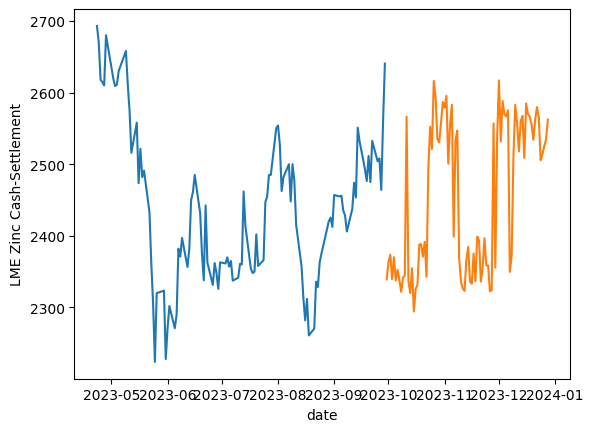

In [254]:
sns.lineplot(working_data.iloc[5500:, 0])
sns.lineplot(adj_df['Final_prognosis'])


---
---